In [1]:
#import gdown
#url = "https://docs.google.com/uc?export=download&id=1xT8E9RJOv1gLFtmkJuI4e-3PUaYs0r9U"
#output_file = "sample.tar"
#gdown.download(url, output_file)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

from utils.pos_enc import encode_position
from utils.volume_op import volume_rendering, volume_sampling_ndc
from utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from utils.training_utils import mse2psnr
from utils.lie_group_helper import convert3x4_4x4

image_dir = 'Royce'
scene_name = 'upload'

['IMG_3789.JPG' 'IMG_3790.JPG' 'IMG_3791.JPG' 'IMG_3792.JPG'
 'IMG_3793.JPG' 'IMG_3794.JPG' 'IMG_3795.JPG' 'IMG_3796.JPG'
 'IMG_3797.JPG' 'IMG_3798.JPG' 'IMG_3799.JPG' 'IMG_3800.JPG'
 'IMG_3802.JPG' 'IMG_3803.JPG' 'IMG_3804.JPG' 'IMG_3805.JPG'
 'IMG_3806.JPG' 'IMG_3807.JPG' 'IMG_3808.JPG' 'IMG_3809.JPG'
 'IMG_3810.JPG' 'IMG_3811.JPG' 'IMG_3812.JPG' 'IMG_3813.JPG'
 'IMG_3814.JPG' 'IMG_3815.JPG' 'IMG_3816.JPG' 'IMG_3817.JPG'
 'IMG_3818.JPG' 'IMG_3819.JPG' 'IMG_3820.JPG' 'IMG_3821.JPG'
 'IMG_3822.JPG' 'IMG_3823.JPG' 'IMG_3824.JPG']
['Royce/IMG_3789.JPG', 'Royce/IMG_3790.JPG', 'Royce/IMG_3791.JPG', 'Royce/IMG_3792.JPG', 'Royce/IMG_3793.JPG', 'Royce/IMG_3794.JPG', 'Royce/IMG_3795.JPG', 'Royce/IMG_3796.JPG', 'Royce/IMG_3797.JPG', 'Royce/IMG_3798.JPG', 'Royce/IMG_3799.JPG', 'Royce/IMG_3800.JPG', 'Royce/IMG_3802.JPG', 'Royce/IMG_3803.JPG', 'Royce/IMG_3804.JPG', 'Royce/IMG_3805.JPG', 'Royce/IMG_3806.JPG', 'Royce/IMG_3807.JPG', 'Royce/IMG_3808.JPG', 'Royce/IMG_3809.JPG', 'Royce/IMG_3810.JPG', 'R

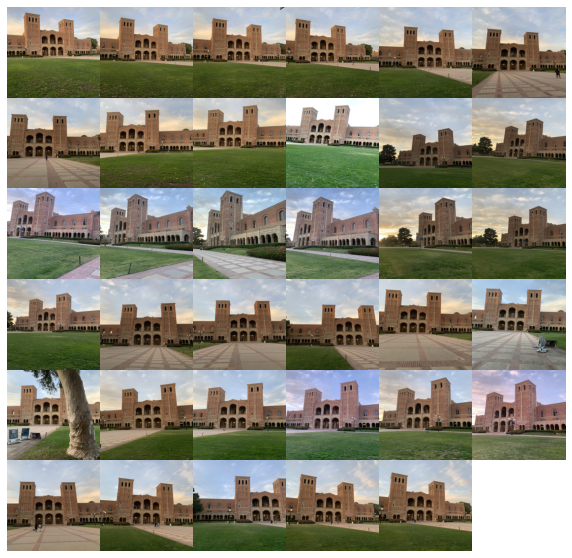

In [22]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs(image_dir)
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(os.path.join('nvs_results', scene_name + 'database' + 'img'))

plt.show()

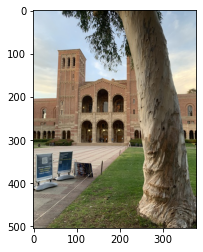

In [37]:
img = imageio.imread('./Royce/IMG_3814.JPG')[:, :, :3]  # (H, W, 3) np.uint8
plt.imshow(img)

In [16]:
import os
len(os.listdir('./Royce'))

35

['IMG_3789.JPG' 'IMG_3790.JPG' 'IMG_3791.JPG' 'IMG_3792.JPG'
 'IMG_3793.JPG' 'IMG_3794.JPG' 'IMG_3795.JPG' 'IMG_3796.JPG'
 'IMG_3797.JPG' 'IMG_3798.JPG' 'IMG_3799.JPG' 'IMG_3800.JPG'
 'IMG_3802.JPG' 'IMG_3803.JPG' 'IMG_3804.JPG' 'IMG_3805.JPG'
 'IMG_3806.JPG' 'IMG_3807.JPG' 'IMG_3808.JPG' 'IMG_3809.JPG'
 'IMG_3810.JPG' 'IMG_3811.JPG' 'IMG_3812.JPG' 'IMG_3813.JPG'
 'IMG_3815.JPG' 'IMG_3816.JPG' 'IMG_3817.JPG' 'IMG_3818.JPG'
 'IMG_3819.JPG' 'IMG_3820.JPG' 'IMG_3821.JPG' 'IMG_3822.JPG'
 'IMG_3823.JPG' 'IMG_3824.JPG']
['Royce_Clean/IMG_3789.JPG', 'Royce_Clean/IMG_3790.JPG', 'Royce_Clean/IMG_3791.JPG', 'Royce_Clean/IMG_3792.JPG', 'Royce_Clean/IMG_3793.JPG', 'Royce_Clean/IMG_3794.JPG', 'Royce_Clean/IMG_3795.JPG', 'Royce_Clean/IMG_3796.JPG', 'Royce_Clean/IMG_3797.JPG', 'Royce_Clean/IMG_3798.JPG', 'Royce_Clean/IMG_3799.JPG', 'Royce_Clean/IMG_3800.JPG', 'Royce_Clean/IMG_3802.JPG', 'Royce_Clean/IMG_3803.JPG', 'Royce_Clean/IMG_3804.JPG', 'Royce_Clean/IMG_3805.JPG', 'Royce_Clean/IMG_3806.JPG', 'Ro

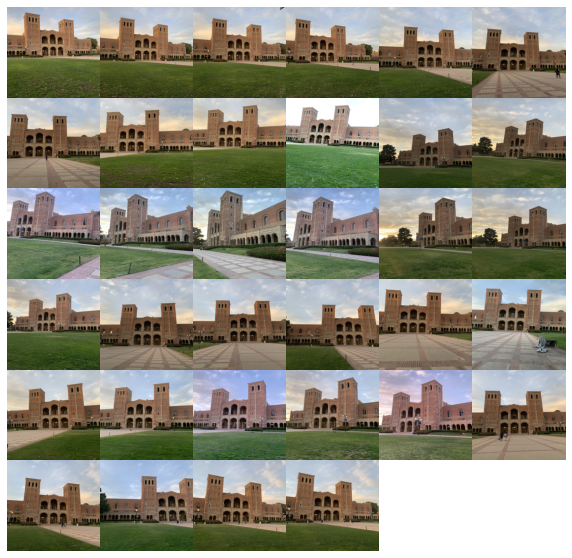

In [21]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs('Royce_Clean')
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(os.path.join('nvs_results', scene_name + 'database' + 'img'))
plt.show()

In [4]:
from model import *

In [5]:
from train import *

In [5]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = Nerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/ec2-user/.conda/envs/colmap/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    0 Training PSNR 12.698, estimated fx 377.7 fy 504.2
epoch    1 Training PSNR 14.971, estimated fx 378.7 fy 501.1
epoch    2 Training PSNR 15.012, estimated fx 380.6 fy 500.6
epoch    3 Training PSNR 14.861, estimated fx 385.6 fy 511.6
epoch    4 Training PSNR 15.076, estimated fx 390.3 fy 527.4
epoch    5 Training PSNR 15.090, estimated fx 391.4 fy 530.6
epoch    6 Training PSNR 15.441, estimated fx 400.7 fy 541.4
epoch    7 Training PSNR 15.359, estimated fx 409.1 fy 558.4
epoch    8 Training PSNR 15.639, estimated fx 418.3 fy 577.0
epoch    9 Training PSNR 15.352, estimated fx 428.6 fy 589.9
epoch   10 Training PSNR 16.060, estimated fx 435.8 fy 600.8
epoch   11 Training PSNR 15.839, estimated fx 448.7 fy 602.6
epoch   12 Training PSNR 16.125, estimated fx 454.9 fy 601.6
epoch   13 Training PSNR 16.012, estimated fx 458.8 fy 603.5
epoch   14 Training PSNR 16.298, estimated fx 467.0 fy 603.0
epoch   15 Training PSNR 16.322, estimated fx 471.4 fy 610.2
epoch   16 Training PSNR

epoch  135 Training PSNR 18.187, estimated fx 475.0 fy 539.4
epoch  136 Training PSNR 18.019, estimated fx 474.3 fy 537.6
epoch  137 Training PSNR 18.408, estimated fx 479.8 fy 537.3
epoch  138 Training PSNR 18.438, estimated fx 471.9 fy 543.7
epoch  139 Training PSNR 18.263, estimated fx 473.5 fy 537.6
epoch  140 Training PSNR 18.271, estimated fx 475.3 fy 534.6
epoch  141 Training PSNR 18.444, estimated fx 473.5 fy 535.3
epoch  142 Training PSNR 18.433, estimated fx 473.9 fy 534.8
epoch  143 Training PSNR 18.351, estimated fx 476.5 fy 536.6
epoch  144 Training PSNR 18.440, estimated fx 476.2 fy 539.6
epoch  145 Training PSNR 18.390, estimated fx 472.3 fy 533.7
epoch  146 Training PSNR 18.435, estimated fx 472.8 fy 533.1
epoch  147 Training PSNR 18.331, estimated fx 473.3 fy 535.5
epoch  148 Training PSNR 18.732, estimated fx 474.0 fy 533.9
epoch  149 Training PSNR 18.658, estimated fx 476.6 fy 530.3
epoch  150 Training PSNR 18.445, estimated fx 474.4 fy 532.6
epoch  151 Training PSNR

epoch  270 Training PSNR 19.858, estimated fx 465.2 fy 483.4
epoch  271 Training PSNR 19.727, estimated fx 464.2 fy 480.8
epoch  272 Training PSNR 19.546, estimated fx 464.3 fy 482.7
epoch  273 Training PSNR 19.808, estimated fx 466.3 fy 479.1
epoch  274 Training PSNR 19.741, estimated fx 465.7 fy 479.5
epoch  275 Training PSNR 19.676, estimated fx 466.0 fy 472.5
epoch  276 Training PSNR 19.199, estimated fx 463.5 fy 480.2
epoch  277 Training PSNR 19.559, estimated fx 461.7 fy 478.0
epoch  278 Training PSNR 19.526, estimated fx 461.9 fy 479.7
epoch  279 Training PSNR 19.845, estimated fx 465.3 fy 481.6
epoch  280 Training PSNR 19.610, estimated fx 465.7 fy 474.7
epoch  281 Training PSNR 19.618, estimated fx 464.6 fy 478.1
epoch  282 Training PSNR 19.620, estimated fx 461.9 fy 481.1
epoch  283 Training PSNR 19.636, estimated fx 470.9 fy 479.1
epoch  284 Training PSNR 19.649, estimated fx 466.1 fy 476.2
epoch  285 Training PSNR 19.704, estimated fx 463.4 fy 475.4
epoch  286 Training PSNR

epoch  405 Training PSNR 20.488, estimated fx 448.1 fy 450.0
epoch  406 Training PSNR 20.428, estimated fx 450.1 fy 450.2
epoch  407 Training PSNR 20.305, estimated fx 445.6 fy 444.5
epoch  408 Training PSNR 20.378, estimated fx 446.6 fy 452.2
epoch  409 Training PSNR 20.520, estimated fx 446.3 fy 451.7
epoch  410 Training PSNR 20.259, estimated fx 446.5 fy 451.4
epoch  411 Training PSNR 20.515, estimated fx 444.5 fy 445.8
epoch  412 Training PSNR 20.565, estimated fx 446.0 fy 449.3
epoch  413 Training PSNR 20.421, estimated fx 447.2 fy 449.3
epoch  414 Training PSNR 20.393, estimated fx 447.4 fy 447.3
epoch  415 Training PSNR 20.400, estimated fx 446.1 fy 449.0
epoch  416 Training PSNR 20.248, estimated fx 446.2 fy 450.7
epoch  417 Training PSNR 20.257, estimated fx 446.1 fy 453.6
epoch  418 Training PSNR 20.419, estimated fx 442.6 fy 447.5
epoch  419 Training PSNR 20.616, estimated fx 445.5 fy 449.2
epoch  420 Training PSNR 20.577, estimated fx 444.9 fy 450.0
epoch  421 Training PSNR

epoch  540 Training PSNR 20.851, estimated fx 433.8 fy 436.6
epoch  541 Training PSNR 20.797, estimated fx 435.7 fy 436.4
epoch  542 Training PSNR 20.791, estimated fx 435.8 fy 435.2
epoch  543 Training PSNR 20.819, estimated fx 435.2 fy 434.3
epoch  544 Training PSNR 20.672, estimated fx 434.9 fy 434.7
epoch  545 Training PSNR 20.688, estimated fx 434.0 fy 432.6
epoch  546 Training PSNR 20.716, estimated fx 437.2 fy 431.0
epoch  547 Training PSNR 21.125, estimated fx 433.5 fy 434.1
epoch  548 Training PSNR 20.789, estimated fx 435.9 fy 434.9
epoch  549 Training PSNR 20.963, estimated fx 434.3 fy 432.7
epoch  550 Training PSNR 20.775, estimated fx 434.8 fy 429.6
epoch  551 Training PSNR 21.031, estimated fx 433.6 fy 429.7
epoch  552 Training PSNR 20.917, estimated fx 437.3 fy 434.7
epoch  553 Training PSNR 20.943, estimated fx 435.8 fy 433.1
epoch  554 Training PSNR 20.816, estimated fx 432.7 fy 436.6
epoch  555 Training PSNR 20.754, estimated fx 434.4 fy 433.3
epoch  556 Training PSNR

epoch  675 Training PSNR 20.770, estimated fx 431.2 fy 423.2
epoch  676 Training PSNR 20.855, estimated fx 427.3 fy 420.9
epoch  677 Training PSNR 21.029, estimated fx 429.8 fy 423.0
epoch  678 Training PSNR 21.144, estimated fx 428.1 fy 421.8
epoch  679 Training PSNR 21.087, estimated fx 427.6 fy 424.6
epoch  680 Training PSNR 21.253, estimated fx 426.6 fy 423.4
epoch  681 Training PSNR 21.156, estimated fx 428.9 fy 423.6
epoch  682 Training PSNR 21.072, estimated fx 427.9 fy 425.3
epoch  683 Training PSNR 21.088, estimated fx 428.7 fy 425.6
epoch  684 Training PSNR 21.147, estimated fx 427.2 fy 423.9
epoch  685 Training PSNR 20.981, estimated fx 426.7 fy 422.3
epoch  686 Training PSNR 20.915, estimated fx 428.2 fy 420.4
epoch  687 Training PSNR 21.196, estimated fx 425.8 fy 423.5
epoch  688 Training PSNR 21.085, estimated fx 424.3 fy 424.8
epoch  689 Training PSNR 21.267, estimated fx 426.7 fy 422.7
epoch  690 Training PSNR 21.279, estimated fx 425.4 fy 423.5
epoch  691 Training PSNR

epoch  810 Training PSNR 20.986, estimated fx 423.7 fy 420.8
epoch  811 Training PSNR 21.453, estimated fx 422.1 fy 418.9
epoch  812 Training PSNR 21.460, estimated fx 422.7 fy 420.1
epoch  813 Training PSNR 21.437, estimated fx 423.2 fy 420.8
epoch  814 Training PSNR 21.371, estimated fx 423.0 fy 420.2
epoch  815 Training PSNR 21.200, estimated fx 423.8 fy 420.3
epoch  816 Training PSNR 21.363, estimated fx 421.3 fy 419.6
epoch  817 Training PSNR 21.474, estimated fx 421.3 fy 419.2
epoch  818 Training PSNR 21.476, estimated fx 421.7 fy 417.8
epoch  819 Training PSNR 21.535, estimated fx 421.0 fy 418.9
epoch  820 Training PSNR 21.491, estimated fx 422.1 fy 419.9
epoch  821 Training PSNR 21.629, estimated fx 423.4 fy 419.1
epoch  822 Training PSNR 21.345, estimated fx 422.2 fy 420.9
epoch  823 Training PSNR 21.292, estimated fx 421.2 fy 418.9
epoch  824 Training PSNR 21.323, estimated fx 420.7 fy 420.9
epoch  825 Training PSNR 21.317, estimated fx 422.7 fy 419.8
epoch  826 Training PSNR

epoch  945 Training PSNR 21.723, estimated fx 419.6 fy 417.9
epoch  946 Training PSNR 21.685, estimated fx 418.7 fy 418.6
epoch  947 Training PSNR 21.430, estimated fx 420.7 fy 414.8
epoch  948 Training PSNR 21.643, estimated fx 421.2 fy 415.0
epoch  949 Training PSNR 21.454, estimated fx 419.5 fy 414.8
epoch  950 Training PSNR 21.630, estimated fx 419.6 fy 415.9
epoch  951 Training PSNR 21.590, estimated fx 417.8 fy 416.9
epoch  952 Training PSNR 21.824, estimated fx 419.1 fy 416.7
epoch  953 Training PSNR 21.713, estimated fx 419.1 fy 414.8
epoch  954 Training PSNR 21.665, estimated fx 420.2 fy 416.9
epoch  955 Training PSNR 21.649, estimated fx 420.0 fy 416.5
epoch  956 Training PSNR 21.953, estimated fx 418.9 fy 417.4
epoch  957 Training PSNR 21.721, estimated fx 421.2 fy 417.1
epoch  958 Training PSNR 21.778, estimated fx 418.9 fy 416.8
epoch  959 Training PSNR 21.686, estimated fx 419.6 fy 416.4
epoch  960 Training PSNR 21.743, estimated fx 420.1 fy 418.3
epoch  961 Training PSNR

In [7]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'normal' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'normal'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 1000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


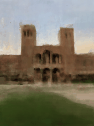

In [8]:
Image(open(os.path.join('nvs_results', scene_name +  'normal' +'_img.gif'), 'rb').read())

## Try Different Nerf Sizes

In [9]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = BigNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch    0 Training PSNR 12.520, estimated fx 377.6 fy 502.6
epoch    1 Training PSNR 14.572, estimated fx 373.1 fy 503.4
epoch    2 Training PSNR 15.059, estimated fx 375.6 fy 510.7
epoch    3 Training PSNR 14.785, estimated fx 376.4 fy 519.1
epoch    4 Training PSNR 15.167, estimated fx 374.2 fy 524.8
epoch    5 Training PSNR 15.362, estimated fx 376.7 fy 539.6
epoch    6 Training PSNR 15.243, estimated fx 380.1 fy 561.0
epoch    7 Training PSNR 15.375, estimated fx 392.4 fy 577.5
epoch    8 Training PSNR 15.400, estimated fx 395.2 fy 584.8
epoch    9 Training PSNR 15.647, estimated fx 415.2 fy 601.7
epoch   10 Training PSNR 15.492, estimated fx 435.5 fy 605.0
epoch   11 Training PSNR 15.794, estimated fx 441.2 fy 623.4
epoch   12 Training PSNR 15.807, estimated fx 463.1 fy 635.6
epoch   13 Training PSNR 15.981, estimated fx 475.2 fy 633.5
epoch   14 Training PSNR 16.019, estimated fx 484.8 fy 646.4
epoch   15 Training PSNR 16.097, estimated fx 495.3 fy 645.2
epoch   16 Training PSNR

epoch  135 Training PSNR 18.573, estimated fx 490.3 fy 598.2
epoch  136 Training PSNR 18.551, estimated fx 490.2 fy 593.8
epoch  137 Training PSNR 18.581, estimated fx 488.6 fy 593.5
epoch  138 Training PSNR 18.467, estimated fx 492.2 fy 587.3
epoch  139 Training PSNR 18.447, estimated fx 488.1 fy 591.7
epoch  140 Training PSNR 18.572, estimated fx 484.2 fy 594.6
epoch  141 Training PSNR 18.637, estimated fx 486.5 fy 592.2
epoch  142 Training PSNR 18.652, estimated fx 487.6 fy 587.7
epoch  143 Training PSNR 18.303, estimated fx 489.3 fy 591.5
epoch  144 Training PSNR 18.574, estimated fx 491.3 fy 584.8
epoch  145 Training PSNR 18.506, estimated fx 488.8 fy 587.2
epoch  146 Training PSNR 18.709, estimated fx 493.8 fy 584.7
epoch  147 Training PSNR 18.554, estimated fx 491.4 fy 592.2
epoch  148 Training PSNR 18.621, estimated fx 485.2 fy 587.3
epoch  149 Training PSNR 18.868, estimated fx 488.3 fy 586.4
epoch  150 Training PSNR 18.686, estimated fx 490.1 fy 584.5
epoch  151 Training PSNR

epoch  270 Training PSNR 19.550, estimated fx 460.4 fy 538.6
epoch  271 Training PSNR 19.646, estimated fx 464.3 fy 534.4
epoch  272 Training PSNR 19.452, estimated fx 463.6 fy 535.5
epoch  273 Training PSNR 19.476, estimated fx 463.3 fy 536.2
epoch  274 Training PSNR 19.840, estimated fx 462.7 fy 532.0
epoch  275 Training PSNR 19.784, estimated fx 460.5 fy 530.3
epoch  276 Training PSNR 19.926, estimated fx 465.2 fy 535.7
epoch  277 Training PSNR 19.648, estimated fx 466.2 fy 530.6
epoch  278 Training PSNR 19.611, estimated fx 462.1 fy 533.8
epoch  279 Training PSNR 19.729, estimated fx 463.8 fy 535.5
epoch  280 Training PSNR 19.534, estimated fx 462.5 fy 534.3
epoch  281 Training PSNR 19.896, estimated fx 462.0 fy 532.9
epoch  282 Training PSNR 19.471, estimated fx 461.5 fy 536.1
epoch  283 Training PSNR 19.690, estimated fx 466.3 fy 534.6
epoch  284 Training PSNR 19.909, estimated fx 462.7 fy 532.7
epoch  285 Training PSNR 19.594, estimated fx 462.6 fy 528.7
epoch  286 Training PSNR

epoch  405 Training PSNR 20.243, estimated fx 448.4 fy 490.9
epoch  406 Training PSNR 20.185, estimated fx 448.1 fy 494.3
epoch  407 Training PSNR 20.553, estimated fx 447.0 fy 494.2
epoch  408 Training PSNR 20.487, estimated fx 446.2 fy 491.3
epoch  409 Training PSNR 19.986, estimated fx 445.2 fy 489.1
epoch  410 Training PSNR 20.360, estimated fx 448.2 fy 493.7
epoch  411 Training PSNR 20.481, estimated fx 444.8 fy 490.9
epoch  412 Training PSNR 20.507, estimated fx 446.0 fy 489.8
epoch  413 Training PSNR 20.355, estimated fx 445.5 fy 489.6
epoch  414 Training PSNR 20.520, estimated fx 444.8 fy 491.9
epoch  415 Training PSNR 20.424, estimated fx 445.8 fy 488.5
epoch  416 Training PSNR 20.219, estimated fx 445.3 fy 491.7
epoch  417 Training PSNR 20.463, estimated fx 446.1 fy 493.4
epoch  418 Training PSNR 20.236, estimated fx 448.0 fy 488.2
epoch  419 Training PSNR 20.205, estimated fx 443.4 fy 488.6
epoch  420 Training PSNR 20.574, estimated fx 445.2 fy 490.2
epoch  421 Training PSNR

epoch  540 Training PSNR 20.921, estimated fx 439.6 fy 471.9
epoch  541 Training PSNR 20.765, estimated fx 438.0 fy 468.6
epoch  542 Training PSNR 20.612, estimated fx 436.9 fy 468.5
epoch  543 Training PSNR 21.004, estimated fx 440.4 fy 468.5
epoch  544 Training PSNR 20.832, estimated fx 438.3 fy 470.8
epoch  545 Training PSNR 20.887, estimated fx 437.3 fy 469.3
epoch  546 Training PSNR 21.024, estimated fx 437.7 fy 467.9
epoch  547 Training PSNR 21.106, estimated fx 436.9 fy 469.1
epoch  548 Training PSNR 20.989, estimated fx 438.0 fy 467.2
epoch  549 Training PSNR 21.162, estimated fx 439.5 fy 467.5
epoch  550 Training PSNR 21.222, estimated fx 436.7 fy 471.4
epoch  551 Training PSNR 20.835, estimated fx 439.1 fy 467.5
epoch  552 Training PSNR 20.783, estimated fx 438.7 fy 470.9
epoch  553 Training PSNR 20.883, estimated fx 436.0 fy 469.0
epoch  554 Training PSNR 20.847, estimated fx 437.6 fy 469.5
epoch  555 Training PSNR 20.925, estimated fx 436.8 fy 471.1
epoch  556 Training PSNR

epoch  675 Training PSNR 21.256, estimated fx 428.0 fy 457.7
epoch  676 Training PSNR 21.232, estimated fx 425.0 fy 458.5
epoch  677 Training PSNR 21.152, estimated fx 425.6 fy 456.5
epoch  678 Training PSNR 21.180, estimated fx 424.4 fy 460.1
epoch  679 Training PSNR 20.940, estimated fx 426.9 fy 454.0
epoch  680 Training PSNR 21.399, estimated fx 426.1 fy 458.1
epoch  681 Training PSNR 21.241, estimated fx 423.0 fy 457.4
epoch  682 Training PSNR 21.185, estimated fx 425.1 fy 458.2
epoch  683 Training PSNR 21.369, estimated fx 425.3 fy 456.7
epoch  684 Training PSNR 21.156, estimated fx 424.2 fy 458.7
epoch  685 Training PSNR 21.226, estimated fx 423.5 fy 456.7
epoch  686 Training PSNR 21.100, estimated fx 424.0 fy 458.4
epoch  687 Training PSNR 21.268, estimated fx 425.0 fy 456.0
epoch  688 Training PSNR 21.147, estimated fx 422.1 fy 458.6
epoch  689 Training PSNR 20.752, estimated fx 428.2 fy 458.6
epoch  690 Training PSNR 21.135, estimated fx 425.9 fy 456.5
epoch  691 Training PSNR

epoch  810 Training PSNR 21.522, estimated fx 417.7 fy 451.2
epoch  811 Training PSNR 21.737, estimated fx 417.6 fy 452.0
epoch  812 Training PSNR 21.724, estimated fx 417.0 fy 451.8
epoch  813 Training PSNR 21.535, estimated fx 417.8 fy 451.2
epoch  814 Training PSNR 21.593, estimated fx 417.5 fy 450.9
epoch  815 Training PSNR 21.398, estimated fx 416.8 fy 450.3
epoch  816 Training PSNR 21.570, estimated fx 418.3 fy 449.3
epoch  817 Training PSNR 21.430, estimated fx 418.8 fy 447.6
epoch  818 Training PSNR 21.240, estimated fx 417.3 fy 450.8
epoch  819 Training PSNR 21.348, estimated fx 417.1 fy 450.3
epoch  820 Training PSNR 21.476, estimated fx 417.8 fy 451.1
epoch  821 Training PSNR 21.615, estimated fx 417.0 fy 450.2
epoch  822 Training PSNR 21.674, estimated fx 417.9 fy 449.5
epoch  823 Training PSNR 21.569, estimated fx 416.6 fy 451.0
epoch  824 Training PSNR 21.659, estimated fx 417.1 fy 449.3
epoch  825 Training PSNR 21.673, estimated fx 418.3 fy 450.6
epoch  826 Training PSNR

epoch  945 Training PSNR 21.829, estimated fx 412.3 fy 444.1
epoch  946 Training PSNR 21.903, estimated fx 413.3 fy 446.6
epoch  947 Training PSNR 21.863, estimated fx 410.8 fy 445.0
epoch  948 Training PSNR 21.533, estimated fx 412.3 fy 444.5
epoch  949 Training PSNR 21.881, estimated fx 413.9 fy 444.5
epoch  950 Training PSNR 22.026, estimated fx 412.4 fy 445.6
epoch  951 Training PSNR 21.827, estimated fx 413.8 fy 443.5
epoch  952 Training PSNR 21.840, estimated fx 412.4 fy 445.3
epoch  953 Training PSNR 21.876, estimated fx 412.1 fy 445.6
epoch  954 Training PSNR 21.930, estimated fx 413.3 fy 443.4
epoch  955 Training PSNR 21.899, estimated fx 413.1 fy 444.8
epoch  956 Training PSNR 21.960, estimated fx 412.0 fy 444.4
epoch  957 Training PSNR 21.683, estimated fx 412.5 fy 445.5
epoch  958 Training PSNR 21.987, estimated fx 412.8 fy 445.1
epoch  959 Training PSNR 21.784, estimated fx 413.6 fy 444.5
epoch  960 Training PSNR 21.574, estimated fx 412.0 fy 443.7
epoch  961 Training PSNR

In [10]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'big' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'big'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 1000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


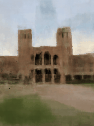

In [11]:
Image(open(os.path.join('nvs_results', scene_name +  'big' +'_img.gif'), 'rb').read())

In [4]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/ec2-user/.conda/envs/colmap/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    0 Training PSNR 12.825, estimated fx 379.4 fy 500.0
epoch    1 Training PSNR 15.014, estimated fx 368.8 fy 510.2
epoch    2 Training PSNR 14.788, estimated fx 371.6 fy 510.7
epoch    3 Training PSNR 15.057, estimated fx 369.7 fy 520.0
epoch    4 Training PSNR 14.955, estimated fx 369.4 fy 526.4
epoch    5 Training PSNR 15.214, estimated fx 368.9 fy 529.2
epoch    6 Training PSNR 15.268, estimated fx 372.3 fy 550.0
epoch    7 Training PSNR 15.265, estimated fx 381.6 fy 561.8
epoch    8 Training PSNR 15.582, estimated fx 390.4 fy 580.1
epoch    9 Training PSNR 15.708, estimated fx 408.9 fy 598.3
epoch   10 Training PSNR 15.730, estimated fx 427.9 fy 616.6
epoch   11 Training PSNR 15.839, estimated fx 434.8 fy 635.7
epoch   12 Training PSNR 15.973, estimated fx 436.7 fy 652.0
epoch   13 Training PSNR 15.959, estimated fx 443.3 fy 674.6
epoch   14 Training PSNR 16.175, estimated fx 450.6 fy 683.6
epoch   15 Training PSNR 16.489, estimated fx 452.6 fy 698.2
epoch   16 Training PSNR

epoch  135 Training PSNR 18.587, estimated fx 453.6 fy 630.2
epoch  136 Training PSNR 18.879, estimated fx 452.5 fy 627.3
epoch  137 Training PSNR 18.525, estimated fx 458.4 fy 630.7
epoch  138 Training PSNR 18.721, estimated fx 453.6 fy 630.3
epoch  139 Training PSNR 18.639, estimated fx 454.3 fy 631.2
epoch  140 Training PSNR 18.668, estimated fx 451.5 fy 628.4
epoch  141 Training PSNR 18.713, estimated fx 450.9 fy 622.8
epoch  142 Training PSNR 18.823, estimated fx 451.3 fy 620.9
epoch  143 Training PSNR 18.675, estimated fx 452.3 fy 623.1
epoch  144 Training PSNR 18.532, estimated fx 451.2 fy 621.3
epoch  145 Training PSNR 18.878, estimated fx 454.3 fy 616.9
epoch  146 Training PSNR 18.515, estimated fx 453.3 fy 618.7
epoch  147 Training PSNR 18.556, estimated fx 449.1 fy 610.3
epoch  148 Training PSNR 18.814, estimated fx 448.6 fy 614.8
epoch  149 Training PSNR 18.973, estimated fx 455.2 fy 613.3
epoch  150 Training PSNR 18.795, estimated fx 447.5 fy 616.1
epoch  151 Training PSNR

epoch  270 Training PSNR 19.586, estimated fx 405.4 fy 563.9
epoch  271 Training PSNR 19.652, estimated fx 406.2 fy 553.6
epoch  272 Training PSNR 19.565, estimated fx 404.6 fy 554.2
epoch  273 Training PSNR 19.563, estimated fx 408.9 fy 554.2
epoch  274 Training PSNR 19.304, estimated fx 409.3 fy 551.6
epoch  275 Training PSNR 19.677, estimated fx 406.4 fy 554.7
epoch  276 Training PSNR 19.858, estimated fx 403.6 fy 552.1
epoch  277 Training PSNR 20.027, estimated fx 403.8 fy 554.0
epoch  278 Training PSNR 19.657, estimated fx 403.6 fy 555.8
epoch  279 Training PSNR 19.664, estimated fx 404.1 fy 550.8
epoch  280 Training PSNR 19.763, estimated fx 405.4 fy 552.5
epoch  281 Training PSNR 19.829, estimated fx 406.7 fy 549.3
epoch  282 Training PSNR 19.647, estimated fx 404.2 fy 551.0
epoch  283 Training PSNR 19.823, estimated fx 403.2 fy 552.7
epoch  284 Training PSNR 19.845, estimated fx 405.2 fy 554.5
epoch  285 Training PSNR 19.788, estimated fx 404.1 fy 552.7
epoch  286 Training PSNR

epoch  410 Training PSNR 20.609, estimated fx 388.2 fy 512.2
epoch  411 Training PSNR 20.380, estimated fx 388.4 fy 511.1
epoch  412 Training PSNR 20.302, estimated fx 388.8 fy 512.2
epoch  413 Training PSNR 20.515, estimated fx 388.2 fy 513.9
epoch  414 Training PSNR 20.733, estimated fx 387.7 fy 515.6
epoch  415 Training PSNR 20.484, estimated fx 386.5 fy 512.8
epoch  416 Training PSNR 20.741, estimated fx 387.7 fy 512.9
epoch  417 Training PSNR 20.397, estimated fx 386.0 fy 511.1
epoch  418 Training PSNR 20.388, estimated fx 384.7 fy 511.2
epoch  419 Training PSNR 20.622, estimated fx 388.5 fy 511.1
epoch  420 Training PSNR 20.763, estimated fx 387.2 fy 510.3
epoch  421 Training PSNR 20.513, estimated fx 387.3 fy 513.3
epoch  422 Training PSNR 20.473, estimated fx 386.0 fy 507.3
epoch  423 Training PSNR 20.655, estimated fx 385.9 fy 510.9
epoch  424 Training PSNR 20.488, estimated fx 385.1 fy 512.9
epoch  425 Training PSNR 20.789, estimated fx 384.9 fy 510.1
epoch  426 Training PSNR

epoch  545 Training PSNR 21.184, estimated fx 373.2 fy 489.7
epoch  546 Training PSNR 20.807, estimated fx 374.2 fy 489.6
epoch  547 Training PSNR 20.854, estimated fx 375.7 fy 484.7
epoch  548 Training PSNR 20.738, estimated fx 373.8 fy 485.3
epoch  549 Training PSNR 20.821, estimated fx 375.3 fy 486.2
epoch  550 Training PSNR 21.178, estimated fx 375.4 fy 486.5
epoch  551 Training PSNR 21.040, estimated fx 375.1 fy 487.0
epoch  552 Training PSNR 21.046, estimated fx 376.4 fy 485.7
epoch  553 Training PSNR 21.256, estimated fx 375.5 fy 484.1
epoch  554 Training PSNR 21.053, estimated fx 374.9 fy 484.2
epoch  555 Training PSNR 21.033, estimated fx 376.5 fy 485.7
epoch  556 Training PSNR 20.988, estimated fx 374.2 fy 485.3
epoch  557 Training PSNR 20.750, estimated fx 374.5 fy 485.3
epoch  558 Training PSNR 20.715, estimated fx 376.0 fy 483.8
epoch  559 Training PSNR 20.842, estimated fx 372.7 fy 483.7
epoch  560 Training PSNR 21.187, estimated fx 373.1 fy 484.4
epoch  561 Training PSNR

epoch  680 Training PSNR 21.062, estimated fx 363.7 fy 470.9
epoch  681 Training PSNR 21.226, estimated fx 364.7 fy 473.5
epoch  682 Training PSNR 21.223, estimated fx 364.5 fy 473.5
epoch  683 Training PSNR 21.307, estimated fx 365.2 fy 474.0
epoch  684 Training PSNR 21.471, estimated fx 362.6 fy 472.8
epoch  685 Training PSNR 21.362, estimated fx 367.2 fy 474.5
epoch  686 Training PSNR 20.934, estimated fx 364.3 fy 474.4
epoch  687 Training PSNR 21.342, estimated fx 363.2 fy 470.9
epoch  688 Training PSNR 21.359, estimated fx 364.8 fy 473.4
epoch  689 Training PSNR 21.247, estimated fx 364.1 fy 473.0
epoch  690 Training PSNR 21.362, estimated fx 363.8 fy 471.9
epoch  691 Training PSNR 21.280, estimated fx 366.4 fy 473.3
epoch  692 Training PSNR 21.240, estimated fx 364.1 fy 470.6
epoch  693 Training PSNR 21.373, estimated fx 365.2 fy 470.8
epoch  694 Training PSNR 21.474, estimated fx 365.0 fy 469.7
epoch  695 Training PSNR 21.288, estimated fx 364.9 fy 469.1
epoch  696 Training PSNR

epoch  815 Training PSNR 21.608, estimated fx 360.7 fy 462.5
epoch  816 Training PSNR 21.521, estimated fx 360.4 fy 463.1
epoch  817 Training PSNR 21.446, estimated fx 359.3 fy 462.6
epoch  818 Training PSNR 21.476, estimated fx 359.8 fy 463.1
epoch  819 Training PSNR 21.549, estimated fx 360.5 fy 463.4
epoch  820 Training PSNR 21.479, estimated fx 360.9 fy 464.3
epoch  821 Training PSNR 21.478, estimated fx 359.7 fy 462.5
epoch  822 Training PSNR 21.283, estimated fx 360.6 fy 461.5
epoch  823 Training PSNR 21.544, estimated fx 358.6 fy 463.0
epoch  824 Training PSNR 21.378, estimated fx 359.4 fy 463.3
epoch  825 Training PSNR 21.703, estimated fx 361.5 fy 462.3
epoch  826 Training PSNR 21.550, estimated fx 359.1 fy 461.3
epoch  827 Training PSNR 21.300, estimated fx 360.5 fy 461.7
epoch  828 Training PSNR 21.415, estimated fx 361.0 fy 462.5
epoch  829 Training PSNR 21.769, estimated fx 359.1 fy 462.4
epoch  830 Training PSNR 21.510, estimated fx 361.1 fy 463.0
epoch  831 Training PSNR

epoch  950 Training PSNR 21.657, estimated fx 357.1 fy 457.9
epoch  951 Training PSNR 21.612, estimated fx 356.0 fy 459.6
epoch  952 Training PSNR 21.707, estimated fx 356.8 fy 459.4
epoch  953 Training PSNR 21.846, estimated fx 357.0 fy 459.7
epoch  954 Training PSNR 21.689, estimated fx 357.0 fy 458.4
epoch  955 Training PSNR 21.909, estimated fx 358.2 fy 459.4
epoch  956 Training PSNR 21.875, estimated fx 357.7 fy 458.3
epoch  957 Training PSNR 21.747, estimated fx 357.6 fy 458.5
epoch  958 Training PSNR 21.703, estimated fx 357.1 fy 456.5
epoch  959 Training PSNR 21.554, estimated fx 356.7 fy 458.3
epoch  960 Training PSNR 21.898, estimated fx 357.4 fy 457.8
epoch  961 Training PSNR 21.975, estimated fx 356.7 fy 457.8
epoch  962 Training PSNR 21.727, estimated fx 357.1 fy 457.8
epoch  963 Training PSNR 21.840, estimated fx 358.1 fy 457.8
epoch  964 Training PSNR 21.779, estimated fx 357.2 fy 457.3
epoch  965 Training PSNR 21.790, estimated fx 358.2 fy 458.5
epoch  966 Training PSNR

In [5]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'normal' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'normal'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 1000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


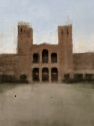

In [6]:
Image(open(os.path.join('nvs_results', scene_name +  'normal' +'_img.gif'), 'rb').read())

## Try Clean Dataset

['IMG_3789.JPG' 'IMG_3790.JPG' 'IMG_3791.JPG' 'IMG_3792.JPG'
 'IMG_3793.JPG' 'IMG_3794.JPG' 'IMG_3795.JPG' 'IMG_3796.JPG'
 'IMG_3797.JPG' 'IMG_3798.JPG' 'IMG_3799.JPG' 'IMG_3800.JPG'
 'IMG_3802.JPG' 'IMG_3803.JPG' 'IMG_3804.JPG' 'IMG_3805.JPG'
 'IMG_3806.JPG' 'IMG_3807.JPG' 'IMG_3808.JPG' 'IMG_3809.JPG'
 'IMG_3810.JPG' 'IMG_3811.JPG' 'IMG_3812.JPG' 'IMG_3813.JPG'
 'IMG_3815.JPG' 'IMG_3816.JPG' 'IMG_3817.JPG' 'IMG_3818.JPG'
 'IMG_3819.JPG' 'IMG_3820.JPG' 'IMG_3821.JPG' 'IMG_3822.JPG'
 'IMG_3823.JPG' 'IMG_3824.JPG']
['Royce_Clean/IMG_3789.JPG', 'Royce_Clean/IMG_3790.JPG', 'Royce_Clean/IMG_3791.JPG', 'Royce_Clean/IMG_3792.JPG', 'Royce_Clean/IMG_3793.JPG', 'Royce_Clean/IMG_3794.JPG', 'Royce_Clean/IMG_3795.JPG', 'Royce_Clean/IMG_3796.JPG', 'Royce_Clean/IMG_3797.JPG', 'Royce_Clean/IMG_3798.JPG', 'Royce_Clean/IMG_3799.JPG', 'Royce_Clean/IMG_3800.JPG', 'Royce_Clean/IMG_3802.JPG', 'Royce_Clean/IMG_3803.JPG', 'Royce_Clean/IMG_3804.JPG', 'Royce_Clean/IMG_3805.JPG', 'Royce_Clean/IMG_3806.JPG', 'Ro

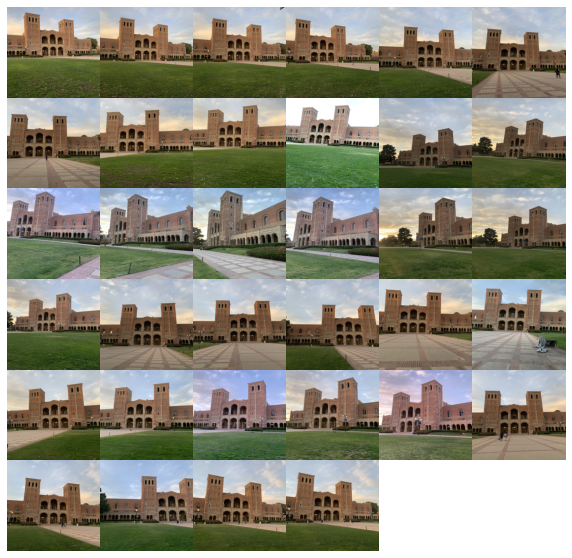

In [20]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs('Royce_Clean')
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)

plt.savefig(os.path.join('nvs_results', scene_name + 'databaseclean' + 'img'))
plt.show()

In [13]:
from model import *
from train import *

N_EPOCH = 3000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = Nerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

epoch    0 Training PSNR 12.182, estimated fx 377.8 fy 502.6
epoch    1 Training PSNR 14.485, estimated fx 384.2 fy 491.7
epoch    2 Training PSNR 14.899, estimated fx 387.5 fy 488.8
epoch    3 Training PSNR 15.071, estimated fx 387.6 fy 490.8
epoch    4 Training PSNR 15.279, estimated fx 389.7 fy 493.5
epoch    5 Training PSNR 15.043, estimated fx 395.9 fy 504.3
epoch    6 Training PSNR 15.504, estimated fx 402.4 fy 515.2
epoch    7 Training PSNR 15.601, estimated fx 416.1 fy 534.5
epoch    8 Training PSNR 15.816, estimated fx 432.2 fy 541.0
epoch    9 Training PSNR 15.453, estimated fx 449.8 fy 560.1
epoch   10 Training PSNR 15.806, estimated fx 455.7 fy 578.7
epoch   11 Training PSNR 16.015, estimated fx 458.9 fy 588.1
epoch   12 Training PSNR 15.973, estimated fx 470.9 fy 598.2
epoch   13 Training PSNR 16.273, estimated fx 478.0 fy 594.5
epoch   14 Training PSNR 16.059, estimated fx 495.6 fy 594.1
epoch   15 Training PSNR 16.384, estimated fx 508.6 fy 594.6
epoch   16 Training PSNR

epoch  135 Training PSNR 18.782, estimated fx 480.7 fy 574.9
epoch  136 Training PSNR 18.709, estimated fx 484.5 fy 576.2
epoch  137 Training PSNR 18.614, estimated fx 479.8 fy 572.7
epoch  138 Training PSNR 18.774, estimated fx 475.8 fy 571.5
epoch  139 Training PSNR 18.558, estimated fx 480.9 fy 573.4
epoch  140 Training PSNR 18.998, estimated fx 478.8 fy 579.0
epoch  141 Training PSNR 18.818, estimated fx 475.3 fy 575.4
epoch  142 Training PSNR 18.820, estimated fx 475.1 fy 573.3
epoch  143 Training PSNR 18.734, estimated fx 476.2 fy 569.6
epoch  144 Training PSNR 18.659, estimated fx 476.0 fy 572.0
epoch  145 Training PSNR 19.045, estimated fx 470.6 fy 568.5
epoch  146 Training PSNR 18.644, estimated fx 473.4 fy 566.4
epoch  147 Training PSNR 18.716, estimated fx 479.5 fy 567.1
epoch  148 Training PSNR 18.661, estimated fx 480.5 fy 571.3
epoch  149 Training PSNR 18.725, estimated fx 478.8 fy 567.7
epoch  150 Training PSNR 18.815, estimated fx 473.0 fy 564.4
epoch  151 Training PSNR

epoch  270 Training PSNR 19.711, estimated fx 435.0 fy 528.2
epoch  271 Training PSNR 19.628, estimated fx 433.9 fy 525.6
epoch  272 Training PSNR 19.514, estimated fx 436.6 fy 526.7
epoch  273 Training PSNR 19.712, estimated fx 437.2 fy 519.2
epoch  274 Training PSNR 19.676, estimated fx 434.9 fy 526.3
epoch  275 Training PSNR 19.535, estimated fx 436.3 fy 523.0
epoch  276 Training PSNR 19.844, estimated fx 438.1 fy 528.5
epoch  277 Training PSNR 19.626, estimated fx 438.6 fy 525.2
epoch  278 Training PSNR 19.713, estimated fx 438.8 fy 523.3
epoch  279 Training PSNR 19.764, estimated fx 437.2 fy 526.3
epoch  280 Training PSNR 19.540, estimated fx 439.7 fy 524.2
epoch  281 Training PSNR 19.741, estimated fx 436.2 fy 522.4
epoch  282 Training PSNR 19.810, estimated fx 437.6 fy 525.0
epoch  283 Training PSNR 19.566, estimated fx 436.6 fy 522.8
epoch  284 Training PSNR 19.780, estimated fx 435.4 fy 524.2
epoch  285 Training PSNR 19.656, estimated fx 441.4 fy 524.6
epoch  286 Training PSNR

epoch  405 Training PSNR 20.429, estimated fx 421.0 fy 499.5
epoch  406 Training PSNR 20.435, estimated fx 422.9 fy 494.6
epoch  407 Training PSNR 20.331, estimated fx 423.7 fy 496.9
epoch  408 Training PSNR 20.362, estimated fx 421.1 fy 495.4
epoch  409 Training PSNR 20.723, estimated fx 421.1 fy 494.7
epoch  410 Training PSNR 20.618, estimated fx 418.8 fy 496.3
epoch  411 Training PSNR 20.607, estimated fx 419.6 fy 491.0
epoch  412 Training PSNR 20.347, estimated fx 416.7 fy 495.1
epoch  413 Training PSNR 20.511, estimated fx 420.4 fy 494.3
epoch  414 Training PSNR 20.457, estimated fx 419.6 fy 497.3
epoch  415 Training PSNR 20.601, estimated fx 421.6 fy 496.7
epoch  416 Training PSNR 20.647, estimated fx 420.6 fy 495.4
epoch  417 Training PSNR 20.665, estimated fx 422.7 fy 497.1
epoch  418 Training PSNR 20.579, estimated fx 418.5 fy 494.2
epoch  419 Training PSNR 20.513, estimated fx 418.8 fy 495.9
epoch  420 Training PSNR 20.567, estimated fx 419.3 fy 496.2
epoch  421 Training PSNR

epoch  540 Training PSNR 21.124, estimated fx 408.9 fy 480.1
epoch  541 Training PSNR 20.974, estimated fx 408.7 fy 481.1
epoch  542 Training PSNR 21.066, estimated fx 408.9 fy 477.4
epoch  543 Training PSNR 20.757, estimated fx 407.4 fy 479.7
epoch  544 Training PSNR 21.025, estimated fx 408.1 fy 477.2
epoch  545 Training PSNR 20.957, estimated fx 408.1 fy 480.3
epoch  546 Training PSNR 20.920, estimated fx 410.5 fy 481.1
epoch  547 Training PSNR 21.135, estimated fx 409.3 fy 478.0
epoch  548 Training PSNR 20.884, estimated fx 409.0 fy 479.3
epoch  549 Training PSNR 20.830, estimated fx 409.0 fy 479.5
epoch  550 Training PSNR 21.021, estimated fx 407.4 fy 480.6
epoch  551 Training PSNR 21.127, estimated fx 409.8 fy 481.4
epoch  552 Training PSNR 20.993, estimated fx 410.5 fy 477.5
epoch  553 Training PSNR 21.169, estimated fx 408.3 fy 478.0
epoch  554 Training PSNR 20.955, estimated fx 408.9 fy 475.3
epoch  555 Training PSNR 20.948, estimated fx 408.7 fy 474.5
epoch  556 Training PSNR

epoch  675 Training PSNR 21.424, estimated fx 402.3 fy 461.3
epoch  676 Training PSNR 21.480, estimated fx 402.5 fy 463.4
epoch  677 Training PSNR 21.309, estimated fx 403.4 fy 462.8
epoch  678 Training PSNR 21.206, estimated fx 401.9 fy 462.8
epoch  679 Training PSNR 21.387, estimated fx 402.9 fy 462.4
epoch  680 Training PSNR 21.489, estimated fx 402.1 fy 461.1
epoch  681 Training PSNR 21.124, estimated fx 403.8 fy 464.5
epoch  682 Training PSNR 21.269, estimated fx 402.0 fy 461.3
epoch  683 Training PSNR 21.187, estimated fx 403.2 fy 461.7
epoch  684 Training PSNR 21.410, estimated fx 400.9 fy 463.1
epoch  685 Training PSNR 21.165, estimated fx 401.5 fy 463.0
epoch  686 Training PSNR 21.084, estimated fx 399.7 fy 461.5
epoch  687 Training PSNR 21.098, estimated fx 402.9 fy 462.2
epoch  688 Training PSNR 21.394, estimated fx 401.1 fy 460.7
epoch  689 Training PSNR 21.080, estimated fx 401.4 fy 462.3
epoch  690 Training PSNR 21.467, estimated fx 400.1 fy 460.1
epoch  691 Training PSNR

epoch  815 Training PSNR 21.751, estimated fx 396.5 fy 456.3
epoch  816 Training PSNR 21.683, estimated fx 394.2 fy 454.2
epoch  817 Training PSNR 21.761, estimated fx 396.4 fy 455.2
epoch  818 Training PSNR 21.611, estimated fx 395.0 fy 458.1
epoch  819 Training PSNR 21.820, estimated fx 396.4 fy 459.0
epoch  820 Training PSNR 21.433, estimated fx 395.9 fy 457.6
epoch  821 Training PSNR 21.761, estimated fx 396.1 fy 455.8
epoch  822 Training PSNR 21.822, estimated fx 397.4 fy 457.7
epoch  823 Training PSNR 21.717, estimated fx 393.8 fy 456.6
epoch  824 Training PSNR 21.641, estimated fx 394.6 fy 456.8
epoch  825 Training PSNR 21.710, estimated fx 395.4 fy 457.2
epoch  826 Training PSNR 21.469, estimated fx 396.2 fy 458.7
epoch  827 Training PSNR 21.763, estimated fx 396.4 fy 456.7
epoch  828 Training PSNR 21.829, estimated fx 396.3 fy 456.7
epoch  829 Training PSNR 21.911, estimated fx 396.9 fy 456.8
epoch  830 Training PSNR 21.710, estimated fx 396.4 fy 456.2
epoch  831 Training PSNR

epoch  950 Training PSNR 21.833, estimated fx 395.7 fy 451.5
epoch  951 Training PSNR 21.658, estimated fx 393.6 fy 452.1
epoch  952 Training PSNR 21.762, estimated fx 395.4 fy 453.4
epoch  953 Training PSNR 21.925, estimated fx 396.9 fy 450.7
epoch  954 Training PSNR 21.876, estimated fx 394.8 fy 452.5
epoch  955 Training PSNR 21.740, estimated fx 396.1 fy 454.4
epoch  956 Training PSNR 21.781, estimated fx 394.7 fy 451.0
epoch  957 Training PSNR 21.946, estimated fx 394.8 fy 452.2
epoch  958 Training PSNR 22.098, estimated fx 395.7 fy 450.6
epoch  959 Training PSNR 22.036, estimated fx 395.1 fy 452.6
epoch  960 Training PSNR 21.977, estimated fx 395.4 fy 451.8
epoch  961 Training PSNR 22.110, estimated fx 393.9 fy 454.5
epoch  962 Training PSNR 22.036, estimated fx 394.4 fy 453.4
epoch  963 Training PSNR 22.158, estimated fx 393.6 fy 452.2
epoch  964 Training PSNR 21.922, estimated fx 394.0 fy 451.2
epoch  965 Training PSNR 21.977, estimated fx 394.3 fy 451.8
epoch  966 Training PSNR

epoch 1085 Training PSNR 22.144, estimated fx 393.5 fy 448.1
epoch 1086 Training PSNR 22.038, estimated fx 393.5 fy 447.4
epoch 1087 Training PSNR 22.067, estimated fx 393.2 fy 448.1
epoch 1088 Training PSNR 22.284, estimated fx 392.8 fy 447.8
epoch 1089 Training PSNR 22.295, estimated fx 394.9 fy 448.1
epoch 1090 Training PSNR 22.288, estimated fx 393.3 fy 448.4
epoch 1091 Training PSNR 22.118, estimated fx 392.5 fy 448.1
epoch 1092 Training PSNR 22.165, estimated fx 394.8 fy 448.4
epoch 1093 Training PSNR 22.604, estimated fx 393.3 fy 447.6
epoch 1094 Training PSNR 22.408, estimated fx 394.5 fy 448.6
epoch 1095 Training PSNR 21.915, estimated fx 394.9 fy 448.0
epoch 1096 Training PSNR 22.090, estimated fx 392.9 fy 449.3
epoch 1097 Training PSNR 22.137, estimated fx 393.2 fy 449.3
epoch 1098 Training PSNR 22.365, estimated fx 394.1 fy 448.5
epoch 1099 Training PSNR 22.306, estimated fx 393.2 fy 449.3
epoch 1100 Training PSNR 22.173, estimated fx 394.9 fy 448.0
epoch 1101 Training PSNR

epoch 1220 Training PSNR 22.402, estimated fx 393.1 fy 446.1
epoch 1221 Training PSNR 22.444, estimated fx 392.9 fy 447.6
epoch 1222 Training PSNR 22.479, estimated fx 392.6 fy 447.7
epoch 1223 Training PSNR 22.550, estimated fx 392.5 fy 447.0
epoch 1224 Training PSNR 22.379, estimated fx 393.7 fy 448.0
epoch 1225 Training PSNR 22.588, estimated fx 393.0 fy 447.4
epoch 1226 Training PSNR 22.562, estimated fx 392.9 fy 447.1
epoch 1227 Training PSNR 22.489, estimated fx 393.2 fy 447.6
epoch 1228 Training PSNR 22.464, estimated fx 392.5 fy 447.4
epoch 1229 Training PSNR 22.344, estimated fx 393.5 fy 449.0
epoch 1230 Training PSNR 22.242, estimated fx 394.1 fy 447.3
epoch 1231 Training PSNR 22.528, estimated fx 394.1 fy 446.7
epoch 1232 Training PSNR 22.492, estimated fx 392.9 fy 447.3
epoch 1233 Training PSNR 22.618, estimated fx 393.4 fy 447.4
epoch 1234 Training PSNR 22.514, estimated fx 392.5 fy 447.0
epoch 1235 Training PSNR 22.775, estimated fx 393.6 fy 448.7
epoch 1236 Training PSNR

epoch 1355 Training PSNR 22.436, estimated fx 392.0 fy 445.9
epoch 1356 Training PSNR 22.444, estimated fx 392.2 fy 446.2
epoch 1357 Training PSNR 22.525, estimated fx 392.4 fy 446.7
epoch 1358 Training PSNR 22.531, estimated fx 391.6 fy 446.8
epoch 1359 Training PSNR 22.334, estimated fx 392.1 fy 447.2
epoch 1360 Training PSNR 22.662, estimated fx 393.1 fy 447.3
epoch 1361 Training PSNR 22.597, estimated fx 392.8 fy 446.9
epoch 1362 Training PSNR 22.660, estimated fx 392.3 fy 446.2
epoch 1363 Training PSNR 22.726, estimated fx 392.1 fy 446.9
epoch 1364 Training PSNR 22.519, estimated fx 392.9 fy 446.8
epoch 1365 Training PSNR 22.632, estimated fx 393.4 fy 445.8
epoch 1366 Training PSNR 22.696, estimated fx 393.2 fy 447.1
epoch 1367 Training PSNR 22.790, estimated fx 393.0 fy 446.8
epoch 1368 Training PSNR 22.714, estimated fx 391.8 fy 445.9
epoch 1369 Training PSNR 22.583, estimated fx 391.7 fy 448.1
epoch 1370 Training PSNR 22.585, estimated fx 391.7 fy 446.8
epoch 1371 Training PSNR

epoch 1490 Training PSNR 22.628, estimated fx 393.2 fy 446.3
epoch 1491 Training PSNR 22.691, estimated fx 393.0 fy 446.0
epoch 1492 Training PSNR 22.676, estimated fx 392.9 fy 446.6
epoch 1493 Training PSNR 22.998, estimated fx 392.9 fy 445.6
epoch 1494 Training PSNR 22.887, estimated fx 393.0 fy 445.9
epoch 1495 Training PSNR 22.897, estimated fx 392.7 fy 446.9
epoch 1496 Training PSNR 22.927, estimated fx 393.0 fy 446.6
epoch 1497 Training PSNR 22.687, estimated fx 393.0 fy 446.4
epoch 1498 Training PSNR 22.681, estimated fx 393.5 fy 446.7
epoch 1499 Training PSNR 22.787, estimated fx 392.9 fy 445.7
epoch 1500 Training PSNR 22.592, estimated fx 392.7 fy 446.2
epoch 1501 Training PSNR 22.996, estimated fx 393.2 fy 447.2
epoch 1502 Training PSNR 22.735, estimated fx 393.2 fy 446.6
epoch 1503 Training PSNR 22.761, estimated fx 392.9 fy 446.1
epoch 1504 Training PSNR 22.723, estimated fx 393.2 fy 445.3
epoch 1505 Training PSNR 22.869, estimated fx 392.7 fy 445.8
epoch 1506 Training PSNR

epoch 1625 Training PSNR 22.849, estimated fx 393.0 fy 447.0
epoch 1626 Training PSNR 23.116, estimated fx 393.1 fy 446.5
epoch 1627 Training PSNR 23.075, estimated fx 392.7 fy 448.0
epoch 1628 Training PSNR 22.911, estimated fx 393.0 fy 447.2
epoch 1629 Training PSNR 22.961, estimated fx 392.2 fy 446.8
epoch 1630 Training PSNR 22.679, estimated fx 393.0 fy 447.6
epoch 1631 Training PSNR 22.797, estimated fx 392.2 fy 446.9
epoch 1632 Training PSNR 22.762, estimated fx 393.0 fy 446.5
epoch 1633 Training PSNR 22.706, estimated fx 392.5 fy 448.0
epoch 1634 Training PSNR 22.663, estimated fx 392.5 fy 447.5
epoch 1635 Training PSNR 22.996, estimated fx 393.1 fy 446.8
epoch 1636 Training PSNR 23.037, estimated fx 393.3 fy 447.9
epoch 1637 Training PSNR 23.007, estimated fx 392.5 fy 447.8
epoch 1638 Training PSNR 22.885, estimated fx 392.9 fy 446.4
epoch 1639 Training PSNR 22.719, estimated fx 393.6 fy 446.2
epoch 1640 Training PSNR 22.990, estimated fx 393.4 fy 446.3
epoch 1641 Training PSNR

epoch 1760 Training PSNR 22.999, estimated fx 393.0 fy 447.0
epoch 1761 Training PSNR 23.118, estimated fx 392.9 fy 447.5
epoch 1762 Training PSNR 22.892, estimated fx 392.8 fy 447.7
epoch 1763 Training PSNR 22.960, estimated fx 392.1 fy 448.0
epoch 1764 Training PSNR 23.017, estimated fx 392.4 fy 448.2
epoch 1765 Training PSNR 23.135, estimated fx 393.1 fy 447.0
epoch 1766 Training PSNR 22.852, estimated fx 393.8 fy 446.4
epoch 1767 Training PSNR 23.085, estimated fx 393.0 fy 446.5
epoch 1768 Training PSNR 23.010, estimated fx 393.4 fy 447.3
epoch 1769 Training PSNR 23.076, estimated fx 393.8 fy 446.9
epoch 1770 Training PSNR 22.889, estimated fx 393.7 fy 446.4
epoch 1771 Training PSNR 22.631, estimated fx 393.8 fy 446.4
epoch 1772 Training PSNR 23.033, estimated fx 393.4 fy 446.4
epoch 1773 Training PSNR 23.189, estimated fx 393.7 fy 446.4
epoch 1774 Training PSNR 23.000, estimated fx 393.2 fy 446.0
epoch 1775 Training PSNR 23.084, estimated fx 393.5 fy 445.5
epoch 1776 Training PSNR

epoch 1895 Training PSNR 23.149, estimated fx 393.2 fy 445.9
epoch 1896 Training PSNR 23.146, estimated fx 393.4 fy 446.6
epoch 1897 Training PSNR 23.364, estimated fx 393.2 fy 446.1
epoch 1898 Training PSNR 23.244, estimated fx 393.8 fy 446.6
epoch 1899 Training PSNR 23.203, estimated fx 393.0 fy 446.5
epoch 1900 Training PSNR 23.171, estimated fx 393.0 fy 446.2
epoch 1901 Training PSNR 23.112, estimated fx 393.5 fy 446.3
epoch 1902 Training PSNR 23.114, estimated fx 393.2 fy 446.6
epoch 1903 Training PSNR 23.037, estimated fx 393.2 fy 446.5
epoch 1904 Training PSNR 23.135, estimated fx 394.0 fy 445.8
epoch 1905 Training PSNR 23.212, estimated fx 393.8 fy 446.0
epoch 1906 Training PSNR 23.302, estimated fx 393.4 fy 446.4
epoch 1907 Training PSNR 23.168, estimated fx 393.2 fy 446.3
epoch 1908 Training PSNR 23.270, estimated fx 394.2 fy 446.8
epoch 1909 Training PSNR 23.106, estimated fx 393.4 fy 447.3
epoch 1910 Training PSNR 23.300, estimated fx 393.5 fy 446.8
epoch 1911 Training PSNR

epoch 2030 Training PSNR 23.420, estimated fx 393.4 fy 447.0
epoch 2031 Training PSNR 23.158, estimated fx 393.4 fy 446.7
epoch 2032 Training PSNR 23.395, estimated fx 393.2 fy 446.6
epoch 2033 Training PSNR 23.599, estimated fx 393.2 fy 447.2
epoch 2034 Training PSNR 23.069, estimated fx 393.6 fy 447.2
epoch 2035 Training PSNR 23.284, estimated fx 393.6 fy 446.9
epoch 2036 Training PSNR 23.130, estimated fx 393.6 fy 447.9
epoch 2037 Training PSNR 23.067, estimated fx 393.6 fy 447.6
epoch 2038 Training PSNR 23.106, estimated fx 393.8 fy 447.8
epoch 2039 Training PSNR 23.196, estimated fx 394.1 fy 447.0
epoch 2040 Training PSNR 23.173, estimated fx 393.4 fy 446.8
epoch 2041 Training PSNR 23.380, estimated fx 393.2 fy 447.4
epoch 2042 Training PSNR 23.353, estimated fx 393.6 fy 447.3
epoch 2043 Training PSNR 23.163, estimated fx 393.9 fy 447.9
epoch 2044 Training PSNR 23.231, estimated fx 393.7 fy 447.2
epoch 2045 Training PSNR 23.216, estimated fx 393.1 fy 447.7
epoch 2046 Training PSNR

epoch 2165 Training PSNR 23.325, estimated fx 394.4 fy 447.2
epoch 2166 Training PSNR 23.434, estimated fx 394.1 fy 446.9
epoch 2167 Training PSNR 23.439, estimated fx 394.6 fy 446.7
epoch 2168 Training PSNR 23.326, estimated fx 394.9 fy 447.4
epoch 2169 Training PSNR 23.365, estimated fx 393.9 fy 447.0
epoch 2170 Training PSNR 23.324, estimated fx 393.9 fy 446.3
epoch 2171 Training PSNR 23.465, estimated fx 394.1 fy 446.4
epoch 2172 Training PSNR 23.408, estimated fx 393.7 fy 446.5
epoch 2173 Training PSNR 23.502, estimated fx 393.9 fy 446.8
epoch 2174 Training PSNR 23.425, estimated fx 394.0 fy 446.4
epoch 2175 Training PSNR 23.451, estimated fx 394.0 fy 447.5
epoch 2176 Training PSNR 23.294, estimated fx 393.9 fy 447.1
epoch 2177 Training PSNR 23.230, estimated fx 394.0 fy 447.1
epoch 2178 Training PSNR 23.517, estimated fx 393.8 fy 446.5
epoch 2179 Training PSNR 23.407, estimated fx 393.6 fy 446.8
epoch 2180 Training PSNR 23.457, estimated fx 393.6 fy 447.0
epoch 2181 Training PSNR

epoch 2300 Training PSNR 23.597, estimated fx 394.3 fy 447.4
epoch 2301 Training PSNR 23.630, estimated fx 394.3 fy 447.5
epoch 2302 Training PSNR 23.189, estimated fx 394.4 fy 447.4
epoch 2303 Training PSNR 23.334, estimated fx 394.0 fy 447.4
epoch 2304 Training PSNR 23.500, estimated fx 394.1 fy 447.6
epoch 2305 Training PSNR 23.427, estimated fx 394.1 fy 447.6
epoch 2306 Training PSNR 23.491, estimated fx 394.1 fy 447.4
epoch 2307 Training PSNR 23.501, estimated fx 394.6 fy 447.0
epoch 2308 Training PSNR 23.554, estimated fx 394.4 fy 447.4
epoch 2309 Training PSNR 23.391, estimated fx 394.4 fy 447.7
epoch 2310 Training PSNR 23.380, estimated fx 393.8 fy 448.0
epoch 2311 Training PSNR 23.438, estimated fx 393.8 fy 447.8
epoch 2312 Training PSNR 23.815, estimated fx 393.9 fy 448.2
epoch 2313 Training PSNR 23.621, estimated fx 394.3 fy 448.2
epoch 2314 Training PSNR 23.372, estimated fx 394.1 fy 448.1
epoch 2315 Training PSNR 23.636, estimated fx 394.2 fy 447.8
epoch 2316 Training PSNR

epoch 2435 Training PSNR 23.681, estimated fx 394.5 fy 447.7
epoch 2436 Training PSNR 23.747, estimated fx 394.4 fy 447.7
epoch 2437 Training PSNR 23.822, estimated fx 394.4 fy 447.6
epoch 2438 Training PSNR 23.301, estimated fx 394.2 fy 447.7
epoch 2439 Training PSNR 23.485, estimated fx 394.4 fy 447.5
epoch 2440 Training PSNR 23.278, estimated fx 394.3 fy 447.8
epoch 2441 Training PSNR 23.820, estimated fx 394.5 fy 447.9
epoch 2442 Training PSNR 23.523, estimated fx 394.3 fy 447.8
epoch 2443 Training PSNR 23.600, estimated fx 394.4 fy 447.8
epoch 2444 Training PSNR 23.550, estimated fx 394.4 fy 448.2
epoch 2445 Training PSNR 23.584, estimated fx 394.2 fy 447.5
epoch 2446 Training PSNR 23.548, estimated fx 394.3 fy 447.9
epoch 2447 Training PSNR 23.408, estimated fx 394.6 fy 447.8
epoch 2448 Training PSNR 23.499, estimated fx 394.6 fy 448.1
epoch 2449 Training PSNR 23.482, estimated fx 394.4 fy 447.9
epoch 2450 Training PSNR 23.730, estimated fx 394.7 fy 447.6
epoch 2451 Training PSNR

epoch 2570 Training PSNR 23.412, estimated fx 394.4 fy 447.5
epoch 2571 Training PSNR 23.733, estimated fx 394.7 fy 447.7
epoch 2572 Training PSNR 23.654, estimated fx 395.0 fy 447.7
epoch 2573 Training PSNR 23.643, estimated fx 395.2 fy 447.5
epoch 2574 Training PSNR 23.596, estimated fx 394.9 fy 447.5
epoch 2575 Training PSNR 23.697, estimated fx 394.7 fy 447.5
epoch 2576 Training PSNR 23.721, estimated fx 394.9 fy 447.7
epoch 2577 Training PSNR 23.619, estimated fx 395.0 fy 448.2
epoch 2578 Training PSNR 23.751, estimated fx 394.8 fy 448.0
epoch 2579 Training PSNR 23.581, estimated fx 394.7 fy 447.9
epoch 2580 Training PSNR 23.907, estimated fx 394.8 fy 448.0
epoch 2581 Training PSNR 23.848, estimated fx 395.1 fy 447.7
epoch 2582 Training PSNR 23.456, estimated fx 394.7 fy 447.8
epoch 2583 Training PSNR 23.534, estimated fx 394.7 fy 447.6
epoch 2584 Training PSNR 23.632, estimated fx 394.6 fy 448.1
epoch 2585 Training PSNR 23.662, estimated fx 394.9 fy 448.0
epoch 2586 Training PSNR

epoch 2705 Training PSNR 23.813, estimated fx 394.6 fy 448.0
epoch 2706 Training PSNR 23.682, estimated fx 394.4 fy 448.0
epoch 2707 Training PSNR 23.720, estimated fx 394.6 fy 448.3
epoch 2708 Training PSNR 23.593, estimated fx 394.7 fy 448.1
epoch 2709 Training PSNR 23.629, estimated fx 394.8 fy 448.0
epoch 2710 Training PSNR 23.799, estimated fx 395.0 fy 448.0
epoch 2711 Training PSNR 23.555, estimated fx 394.9 fy 447.8
epoch 2712 Training PSNR 23.786, estimated fx 394.7 fy 447.9
epoch 2713 Training PSNR 23.662, estimated fx 394.6 fy 447.8
epoch 2714 Training PSNR 23.776, estimated fx 394.7 fy 447.8
epoch 2715 Training PSNR 23.816, estimated fx 394.7 fy 448.0
epoch 2716 Training PSNR 23.718, estimated fx 394.7 fy 448.4
epoch 2717 Training PSNR 23.818, estimated fx 394.5 fy 448.6
epoch 2718 Training PSNR 23.973, estimated fx 394.3 fy 448.9
epoch 2719 Training PSNR 23.810, estimated fx 394.5 fy 448.7
epoch 2720 Training PSNR 24.009, estimated fx 394.4 fy 448.5
epoch 2721 Training PSNR

epoch 2840 Training PSNR 24.178, estimated fx 394.4 fy 448.1
epoch 2841 Training PSNR 23.767, estimated fx 394.6 fy 448.2
epoch 2842 Training PSNR 23.879, estimated fx 394.5 fy 448.0
epoch 2843 Training PSNR 23.609, estimated fx 394.4 fy 448.0
epoch 2844 Training PSNR 23.850, estimated fx 394.2 fy 447.9
epoch 2845 Training PSNR 23.984, estimated fx 394.6 fy 448.0
epoch 2846 Training PSNR 23.975, estimated fx 394.4 fy 447.9
epoch 2847 Training PSNR 24.017, estimated fx 394.6 fy 447.5
epoch 2848 Training PSNR 23.800, estimated fx 394.6 fy 447.5
epoch 2849 Training PSNR 23.640, estimated fx 394.7 fy 447.5
epoch 2850 Training PSNR 23.739, estimated fx 394.8 fy 447.9
epoch 2851 Training PSNR 23.872, estimated fx 394.5 fy 448.1
epoch 2852 Training PSNR 23.969, estimated fx 394.4 fy 448.5
epoch 2853 Training PSNR 24.019, estimated fx 394.5 fy 448.1
epoch 2854 Training PSNR 23.757, estimated fx 394.4 fy 447.7
epoch 2855 Training PSNR 23.687, estimated fx 394.3 fy 447.8
epoch 2856 Training PSNR

epoch 2975 Training PSNR 23.991, estimated fx 394.7 fy 447.9
epoch 2976 Training PSNR 24.030, estimated fx 394.6 fy 447.8
epoch 2977 Training PSNR 23.809, estimated fx 394.7 fy 447.8
epoch 2978 Training PSNR 23.833, estimated fx 395.0 fy 447.8
epoch 2979 Training PSNR 24.157, estimated fx 395.1 fy 447.8
epoch 2980 Training PSNR 23.999, estimated fx 394.9 fy 447.8
epoch 2981 Training PSNR 23.999, estimated fx 394.9 fy 447.9
epoch 2982 Training PSNR 23.849, estimated fx 394.9 fy 448.1
epoch 2983 Training PSNR 23.841, estimated fx 394.7 fy 448.3
epoch 2984 Training PSNR 23.748, estimated fx 394.5 fy 448.2
epoch 2985 Training PSNR 23.922, estimated fx 394.6 fy 448.3
epoch 2986 Training PSNR 23.657, estimated fx 394.6 fy 448.1
epoch 2987 Training PSNR 23.926, estimated fx 394.6 fy 448.2
epoch 2988 Training PSNR 23.737, estimated fx 394.4 fy 448.2
epoch 2989 Training PSNR 23.982, estimated fx 394.7 fy 448.3
epoch 2990 Training PSNR 23.773, estimated fx 394.8 fy 448.1
epoch 2991 Training PSNR

In [14]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'clean' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'clean'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 3000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


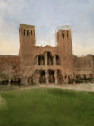

In [15]:
Image(open(os.path.join('nvs_results', scene_name +  'clean' +'_img.gif'), 'rb').read())

In [16]:
from model import *
from train import *

N_EPOCH = 3000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

epoch    0 Training PSNR 12.336, estimated fx 377.9 fy 502.8
epoch    1 Training PSNR 14.786, estimated fx 380.8 fy 495.6
epoch    2 Training PSNR 15.186, estimated fx 388.3 fy 494.8
epoch    3 Training PSNR 15.172, estimated fx 390.6 fy 503.7
epoch    4 Training PSNR 15.080, estimated fx 399.7 fy 512.6
epoch    5 Training PSNR 15.303, estimated fx 405.2 fy 528.3
epoch    6 Training PSNR 15.404, estimated fx 413.7 fy 542.6
epoch    7 Training PSNR 15.723, estimated fx 420.8 fy 558.6
epoch    8 Training PSNR 15.981, estimated fx 430.0 fy 586.8
epoch    9 Training PSNR 15.792, estimated fx 429.2 fy 603.4
epoch   10 Training PSNR 16.170, estimated fx 433.0 fy 608.0
epoch   11 Training PSNR 16.280, estimated fx 429.4 fy 618.8
epoch   12 Training PSNR 16.179, estimated fx 427.3 fy 627.9
epoch   13 Training PSNR 16.266, estimated fx 420.9 fy 631.4
epoch   14 Training PSNR 16.368, estimated fx 418.7 fy 644.3
epoch   15 Training PSNR 16.450, estimated fx 414.9 fy 660.6
epoch   16 Training PSNR

epoch  135 Training PSNR 18.942, estimated fx 459.2 fy 620.9
epoch  136 Training PSNR 18.916, estimated fx 461.4 fy 621.8
epoch  137 Training PSNR 18.766, estimated fx 457.6 fy 621.5
epoch  138 Training PSNR 18.753, estimated fx 455.4 fy 622.4
epoch  139 Training PSNR 19.155, estimated fx 454.8 fy 622.2
epoch  140 Training PSNR 18.962, estimated fx 455.3 fy 618.6
epoch  141 Training PSNR 19.026, estimated fx 455.8 fy 613.2
epoch  142 Training PSNR 19.071, estimated fx 454.2 fy 609.3
epoch  143 Training PSNR 18.963, estimated fx 450.1 fy 610.6
epoch  144 Training PSNR 19.073, estimated fx 454.8 fy 608.4
epoch  145 Training PSNR 19.145, estimated fx 449.2 fy 606.6
epoch  146 Training PSNR 19.050, estimated fx 449.9 fy 601.8
epoch  147 Training PSNR 19.171, estimated fx 449.6 fy 608.2
epoch  148 Training PSNR 19.361, estimated fx 449.0 fy 601.6
epoch  149 Training PSNR 19.227, estimated fx 451.0 fy 602.9
epoch  150 Training PSNR 19.211, estimated fx 447.5 fy 603.7
epoch  151 Training PSNR

epoch  270 Training PSNR 19.842, estimated fx 399.7 fy 535.5
epoch  271 Training PSNR 20.011, estimated fx 398.1 fy 538.5
epoch  272 Training PSNR 20.123, estimated fx 400.4 fy 534.9
epoch  273 Training PSNR 19.763, estimated fx 399.6 fy 534.4
epoch  274 Training PSNR 20.110, estimated fx 400.3 fy 532.9
epoch  275 Training PSNR 20.018, estimated fx 399.5 fy 534.0
epoch  276 Training PSNR 20.080, estimated fx 398.2 fy 534.0
epoch  277 Training PSNR 20.237, estimated fx 402.2 fy 527.2
epoch  278 Training PSNR 19.945, estimated fx 399.8 fy 534.5
epoch  279 Training PSNR 19.887, estimated fx 400.2 fy 530.1
epoch  280 Training PSNR 19.957, estimated fx 397.4 fy 532.0
epoch  281 Training PSNR 20.031, estimated fx 396.3 fy 530.3
epoch  282 Training PSNR 19.942, estimated fx 397.5 fy 526.5
epoch  283 Training PSNR 20.095, estimated fx 398.1 fy 527.2
epoch  284 Training PSNR 20.013, estimated fx 397.1 fy 532.4
epoch  285 Training PSNR 19.850, estimated fx 394.4 fy 530.9
epoch  286 Training PSNR

epoch  405 Training PSNR 20.519, estimated fx 370.3 fy 491.6
epoch  406 Training PSNR 20.479, estimated fx 371.3 fy 492.4
epoch  407 Training PSNR 20.713, estimated fx 369.1 fy 493.2
epoch  408 Training PSNR 20.434, estimated fx 370.8 fy 489.2
epoch  409 Training PSNR 20.719, estimated fx 369.1 fy 492.5
epoch  410 Training PSNR 20.399, estimated fx 368.8 fy 492.9
epoch  411 Training PSNR 20.621, estimated fx 369.4 fy 488.4
epoch  412 Training PSNR 20.200, estimated fx 371.7 fy 494.2
epoch  413 Training PSNR 20.424, estimated fx 371.6 fy 493.4
epoch  414 Training PSNR 20.503, estimated fx 370.5 fy 489.0
epoch  415 Training PSNR 20.486, estimated fx 369.3 fy 490.5
epoch  416 Training PSNR 20.497, estimated fx 369.4 fy 491.5
epoch  417 Training PSNR 20.557, estimated fx 369.9 fy 489.3
epoch  418 Training PSNR 20.483, estimated fx 368.8 fy 488.3
epoch  419 Training PSNR 20.340, estimated fx 368.5 fy 491.2
epoch  420 Training PSNR 20.701, estimated fx 370.2 fy 491.1
epoch  421 Training PSNR

epoch  540 Training PSNR 21.061, estimated fx 356.3 fy 470.3
epoch  541 Training PSNR 20.578, estimated fx 357.3 fy 468.7
epoch  542 Training PSNR 20.923, estimated fx 356.7 fy 467.6
epoch  543 Training PSNR 20.690, estimated fx 358.0 fy 467.7
epoch  544 Training PSNR 20.790, estimated fx 356.4 fy 470.0
epoch  545 Training PSNR 21.010, estimated fx 356.5 fy 468.4
epoch  546 Training PSNR 20.741, estimated fx 356.6 fy 467.9
epoch  547 Training PSNR 21.043, estimated fx 356.1 fy 465.4
epoch  548 Training PSNR 20.830, estimated fx 357.0 fy 464.5
epoch  549 Training PSNR 21.068, estimated fx 357.3 fy 466.7
epoch  550 Training PSNR 20.919, estimated fx 354.2 fy 467.7
epoch  551 Training PSNR 20.918, estimated fx 356.5 fy 467.9
epoch  552 Training PSNR 21.081, estimated fx 357.2 fy 465.3
epoch  553 Training PSNR 21.042, estimated fx 356.3 fy 466.8
epoch  554 Training PSNR 20.583, estimated fx 354.5 fy 467.2
epoch  555 Training PSNR 20.858, estimated fx 356.6 fy 466.9
epoch  556 Training PSNR

epoch  675 Training PSNR 21.358, estimated fx 348.9 fy 451.8
epoch  676 Training PSNR 21.025, estimated fx 350.4 fy 450.4
epoch  677 Training PSNR 21.273, estimated fx 349.9 fy 451.2
epoch  678 Training PSNR 20.950, estimated fx 349.3 fy 449.9
epoch  679 Training PSNR 21.306, estimated fx 348.6 fy 450.9
epoch  680 Training PSNR 21.233, estimated fx 350.7 fy 449.1
epoch  681 Training PSNR 21.205, estimated fx 349.5 fy 450.0
epoch  682 Training PSNR 21.422, estimated fx 348.5 fy 450.4
epoch  683 Training PSNR 21.212, estimated fx 349.7 fy 451.8
epoch  684 Training PSNR 21.354, estimated fx 349.6 fy 451.5
epoch  685 Training PSNR 21.321, estimated fx 349.4 fy 450.1
epoch  686 Training PSNR 21.206, estimated fx 352.0 fy 449.1
epoch  687 Training PSNR 21.346, estimated fx 350.6 fy 450.2
epoch  688 Training PSNR 21.516, estimated fx 349.8 fy 450.9
epoch  689 Training PSNR 21.354, estimated fx 348.5 fy 449.3
epoch  690 Training PSNR 21.069, estimated fx 349.6 fy 451.6
epoch  691 Training PSNR

epoch  810 Training PSNR 21.706, estimated fx 343.0 fy 438.7
epoch  811 Training PSNR 21.501, estimated fx 343.8 fy 440.2
epoch  812 Training PSNR 21.709, estimated fx 344.0 fy 438.6
epoch  813 Training PSNR 21.809, estimated fx 344.5 fy 438.2
epoch  814 Training PSNR 21.642, estimated fx 344.1 fy 439.1
epoch  815 Training PSNR 21.660, estimated fx 344.3 fy 436.6
epoch  816 Training PSNR 21.528, estimated fx 344.7 fy 437.8
epoch  817 Training PSNR 21.766, estimated fx 345.5 fy 440.2
epoch  818 Training PSNR 21.516, estimated fx 344.4 fy 437.3
epoch  819 Training PSNR 21.756, estimated fx 344.9 fy 438.4
epoch  820 Training PSNR 21.542, estimated fx 346.4 fy 440.7
epoch  821 Training PSNR 21.407, estimated fx 345.3 fy 438.4
epoch  822 Training PSNR 21.365, estimated fx 344.6 fy 441.6
epoch  823 Training PSNR 21.653, estimated fx 345.7 fy 438.1
epoch  824 Training PSNR 21.543, estimated fx 344.5 fy 438.0
epoch  825 Training PSNR 21.853, estimated fx 345.8 fy 439.0
epoch  826 Training PSNR

epoch  945 Training PSNR 21.844, estimated fx 343.1 fy 435.3
epoch  946 Training PSNR 21.731, estimated fx 342.9 fy 434.8
epoch  947 Training PSNR 21.815, estimated fx 343.2 fy 434.4
epoch  948 Training PSNR 21.604, estimated fx 342.5 fy 433.7
epoch  949 Training PSNR 21.840, estimated fx 342.0 fy 434.5
epoch  950 Training PSNR 21.696, estimated fx 342.1 fy 434.1
epoch  951 Training PSNR 21.768, estimated fx 343.2 fy 433.9
epoch  952 Training PSNR 21.555, estimated fx 341.8 fy 432.3
epoch  953 Training PSNR 21.743, estimated fx 343.0 fy 434.3
epoch  954 Training PSNR 22.036, estimated fx 341.6 fy 433.9
epoch  955 Training PSNR 21.725, estimated fx 342.2 fy 434.1
epoch  956 Training PSNR 21.772, estimated fx 342.8 fy 432.1
epoch  957 Training PSNR 21.746, estimated fx 342.9 fy 433.1
epoch  958 Training PSNR 21.781, estimated fx 343.3 fy 434.6
epoch  959 Training PSNR 21.852, estimated fx 343.3 fy 433.7
epoch  960 Training PSNR 21.901, estimated fx 343.0 fy 433.3
epoch  961 Training PSNR

epoch 1080 Training PSNR 21.876, estimated fx 342.2 fy 429.5
epoch 1081 Training PSNR 21.854, estimated fx 342.0 fy 429.8
epoch 1082 Training PSNR 21.827, estimated fx 340.7 fy 430.4
epoch 1083 Training PSNR 22.103, estimated fx 341.7 fy 428.9
epoch 1084 Training PSNR 22.111, estimated fx 342.1 fy 430.4
epoch 1085 Training PSNR 22.038, estimated fx 342.5 fy 431.6
epoch 1086 Training PSNR 21.929, estimated fx 342.1 fy 430.0
epoch 1087 Training PSNR 21.805, estimated fx 342.6 fy 430.2
epoch 1088 Training PSNR 22.196, estimated fx 342.6 fy 429.4
epoch 1089 Training PSNR 21.764, estimated fx 341.1 fy 430.8
epoch 1090 Training PSNR 21.901, estimated fx 342.3 fy 429.2
epoch 1091 Training PSNR 21.923, estimated fx 342.0 fy 431.0
epoch 1092 Training PSNR 21.768, estimated fx 344.1 fy 430.8
epoch 1093 Training PSNR 21.964, estimated fx 342.6 fy 429.2
epoch 1094 Training PSNR 21.894, estimated fx 341.5 fy 427.5
epoch 1095 Training PSNR 21.928, estimated fx 341.8 fy 427.2
epoch 1096 Training PSNR

epoch 1215 Training PSNR 22.347, estimated fx 342.6 fy 429.2
epoch 1216 Training PSNR 22.186, estimated fx 342.1 fy 428.0
epoch 1217 Training PSNR 21.990, estimated fx 343.0 fy 427.8
epoch 1218 Training PSNR 22.296, estimated fx 342.7 fy 428.1
epoch 1219 Training PSNR 22.269, estimated fx 342.9 fy 428.5
epoch 1220 Training PSNR 22.210, estimated fx 342.6 fy 428.5
epoch 1221 Training PSNR 22.337, estimated fx 343.0 fy 427.6
epoch 1222 Training PSNR 22.009, estimated fx 343.2 fy 428.1
epoch 1223 Training PSNR 22.085, estimated fx 342.4 fy 428.9
epoch 1224 Training PSNR 22.398, estimated fx 342.3 fy 426.4
epoch 1225 Training PSNR 22.085, estimated fx 342.4 fy 427.1
epoch 1226 Training PSNR 22.090, estimated fx 341.6 fy 426.3
epoch 1227 Training PSNR 22.006, estimated fx 342.2 fy 429.0
epoch 1228 Training PSNR 22.231, estimated fx 341.5 fy 427.8
epoch 1229 Training PSNR 22.151, estimated fx 342.0 fy 427.3
epoch 1230 Training PSNR 22.084, estimated fx 341.9 fy 426.7
epoch 1231 Training PSNR

epoch 1350 Training PSNR 22.571, estimated fx 342.6 fy 426.3
epoch 1351 Training PSNR 22.256, estimated fx 341.3 fy 426.0
epoch 1352 Training PSNR 22.372, estimated fx 340.8 fy 424.4
epoch 1353 Training PSNR 22.348, estimated fx 341.7 fy 424.6
epoch 1354 Training PSNR 22.237, estimated fx 342.3 fy 426.1
epoch 1355 Training PSNR 22.099, estimated fx 342.0 fy 425.6
epoch 1356 Training PSNR 22.267, estimated fx 342.2 fy 426.0
epoch 1357 Training PSNR 22.185, estimated fx 342.3 fy 425.8
epoch 1358 Training PSNR 22.056, estimated fx 341.2 fy 424.9
epoch 1359 Training PSNR 22.245, estimated fx 342.3 fy 425.5
epoch 1360 Training PSNR 22.225, estimated fx 341.8 fy 425.2
epoch 1361 Training PSNR 21.943, estimated fx 342.3 fy 425.2
epoch 1362 Training PSNR 22.096, estimated fx 340.8 fy 425.7
epoch 1363 Training PSNR 22.121, estimated fx 342.1 fy 426.0
epoch 1364 Training PSNR 22.214, estimated fx 342.1 fy 425.9
epoch 1365 Training PSNR 22.140, estimated fx 342.4 fy 425.0
epoch 1366 Training PSNR

epoch 1485 Training PSNR 22.629, estimated fx 342.1 fy 425.4
epoch 1486 Training PSNR 22.524, estimated fx 342.1 fy 424.8
epoch 1487 Training PSNR 22.310, estimated fx 341.4 fy 424.9
epoch 1488 Training PSNR 22.378, estimated fx 341.8 fy 426.2
epoch 1489 Training PSNR 22.199, estimated fx 341.7 fy 425.1
epoch 1490 Training PSNR 22.223, estimated fx 342.2 fy 424.2
epoch 1491 Training PSNR 22.463, estimated fx 341.9 fy 424.6
epoch 1492 Training PSNR 22.341, estimated fx 342.4 fy 425.5
epoch 1493 Training PSNR 22.380, estimated fx 342.1 fy 424.2
epoch 1494 Training PSNR 22.398, estimated fx 341.9 fy 424.9
epoch 1495 Training PSNR 22.375, estimated fx 342.3 fy 424.2
epoch 1496 Training PSNR 22.372, estimated fx 342.4 fy 425.8
epoch 1497 Training PSNR 22.404, estimated fx 340.8 fy 424.3
epoch 1498 Training PSNR 22.366, estimated fx 342.1 fy 424.4
epoch 1499 Training PSNR 22.447, estimated fx 341.5 fy 424.4
epoch 1500 Training PSNR 22.320, estimated fx 341.6 fy 425.2
epoch 1501 Training PSNR

epoch 1620 Training PSNR 22.348, estimated fx 340.7 fy 426.2
epoch 1621 Training PSNR 22.467, estimated fx 341.0 fy 425.1
epoch 1622 Training PSNR 22.605, estimated fx 341.3 fy 425.0
epoch 1623 Training PSNR 22.429, estimated fx 340.6 fy 425.2
epoch 1624 Training PSNR 22.326, estimated fx 341.2 fy 426.4
epoch 1625 Training PSNR 22.590, estimated fx 340.8 fy 425.7
epoch 1626 Training PSNR 22.714, estimated fx 340.8 fy 425.6
epoch 1627 Training PSNR 22.522, estimated fx 341.7 fy 426.1
epoch 1628 Training PSNR 22.510, estimated fx 340.8 fy 425.0
epoch 1629 Training PSNR 22.306, estimated fx 341.3 fy 425.5
epoch 1630 Training PSNR 22.663, estimated fx 341.3 fy 425.0
epoch 1631 Training PSNR 22.312, estimated fx 341.2 fy 424.9
epoch 1632 Training PSNR 22.383, estimated fx 341.2 fy 425.2
epoch 1633 Training PSNR 22.504, estimated fx 340.9 fy 425.8
epoch 1634 Training PSNR 22.464, estimated fx 341.3 fy 425.2
epoch 1635 Training PSNR 22.616, estimated fx 341.7 fy 424.5
epoch 1636 Training PSNR

epoch 1755 Training PSNR 22.654, estimated fx 342.9 fy 425.5
epoch 1756 Training PSNR 22.544, estimated fx 342.6 fy 424.3
epoch 1757 Training PSNR 22.663, estimated fx 342.6 fy 424.3
epoch 1758 Training PSNR 22.564, estimated fx 342.4 fy 424.1
epoch 1759 Training PSNR 22.585, estimated fx 342.1 fy 424.3
epoch 1760 Training PSNR 22.678, estimated fx 342.4 fy 424.1
epoch 1761 Training PSNR 22.640, estimated fx 342.3 fy 423.9
epoch 1762 Training PSNR 22.466, estimated fx 342.8 fy 423.9
epoch 1763 Training PSNR 22.747, estimated fx 342.3 fy 424.4
epoch 1764 Training PSNR 22.659, estimated fx 342.6 fy 424.2
epoch 1765 Training PSNR 22.590, estimated fx 342.0 fy 424.3
epoch 1766 Training PSNR 22.817, estimated fx 342.5 fy 424.1
epoch 1767 Training PSNR 22.515, estimated fx 342.5 fy 424.6
epoch 1768 Training PSNR 22.639, estimated fx 342.5 fy 424.4
epoch 1769 Training PSNR 22.889, estimated fx 342.3 fy 424.6
epoch 1770 Training PSNR 22.547, estimated fx 342.4 fy 424.3
epoch 1771 Training PSNR

epoch 1890 Training PSNR 22.791, estimated fx 341.8 fy 423.8
epoch 1891 Training PSNR 22.578, estimated fx 341.5 fy 424.5
epoch 1892 Training PSNR 22.527, estimated fx 341.7 fy 424.5
epoch 1893 Training PSNR 22.491, estimated fx 342.3 fy 424.9
epoch 1894 Training PSNR 22.743, estimated fx 342.4 fy 424.4
epoch 1895 Training PSNR 22.644, estimated fx 342.1 fy 424.9
epoch 1896 Training PSNR 22.572, estimated fx 342.6 fy 425.0
epoch 1897 Training PSNR 22.697, estimated fx 342.0 fy 425.0
epoch 1898 Training PSNR 22.773, estimated fx 342.6 fy 424.3
epoch 1899 Training PSNR 22.763, estimated fx 342.6 fy 423.8
epoch 1900 Training PSNR 22.777, estimated fx 342.5 fy 424.2
epoch 1901 Training PSNR 22.733, estimated fx 342.4 fy 424.1
epoch 1902 Training PSNR 22.513, estimated fx 342.3 fy 423.5
epoch 1903 Training PSNR 22.765, estimated fx 342.9 fy 423.7
epoch 1904 Training PSNR 22.701, estimated fx 342.8 fy 424.1
epoch 1905 Training PSNR 22.771, estimated fx 342.6 fy 424.0
epoch 1906 Training PSNR

epoch 2025 Training PSNR 22.981, estimated fx 341.7 fy 424.8
epoch 2026 Training PSNR 22.643, estimated fx 342.4 fy 424.6
epoch 2027 Training PSNR 22.684, estimated fx 342.2 fy 424.4
epoch 2028 Training PSNR 22.879, estimated fx 342.3 fy 424.7
epoch 2029 Training PSNR 22.809, estimated fx 342.4 fy 425.1
epoch 2030 Training PSNR 22.685, estimated fx 342.8 fy 425.1
epoch 2031 Training PSNR 22.811, estimated fx 342.2 fy 424.9
epoch 2032 Training PSNR 22.692, estimated fx 342.6 fy 424.5
epoch 2033 Training PSNR 22.739, estimated fx 342.9 fy 424.4
epoch 2034 Training PSNR 22.869, estimated fx 342.8 fy 424.6
epoch 2035 Training PSNR 22.844, estimated fx 342.4 fy 424.6
epoch 2036 Training PSNR 22.764, estimated fx 342.2 fy 424.8
epoch 2037 Training PSNR 22.865, estimated fx 342.3 fy 424.9
epoch 2038 Training PSNR 22.729, estimated fx 342.0 fy 424.8
epoch 2039 Training PSNR 22.795, estimated fx 342.4 fy 424.5
epoch 2040 Training PSNR 22.857, estimated fx 342.8 fy 424.7
epoch 2041 Training PSNR

epoch 2160 Training PSNR 22.935, estimated fx 343.0 fy 424.2
epoch 2161 Training PSNR 23.028, estimated fx 342.8 fy 424.2
epoch 2162 Training PSNR 23.053, estimated fx 342.9 fy 423.8
epoch 2163 Training PSNR 23.037, estimated fx 343.1 fy 423.9
epoch 2164 Training PSNR 22.793, estimated fx 342.9 fy 424.4
epoch 2165 Training PSNR 22.916, estimated fx 342.9 fy 424.3
epoch 2166 Training PSNR 23.145, estimated fx 342.8 fy 423.7
epoch 2167 Training PSNR 22.989, estimated fx 342.4 fy 423.5
epoch 2168 Training PSNR 22.730, estimated fx 342.4 fy 424.3
epoch 2169 Training PSNR 23.137, estimated fx 342.8 fy 424.5
epoch 2170 Training PSNR 22.766, estimated fx 343.0 fy 423.8
epoch 2171 Training PSNR 22.898, estimated fx 343.0 fy 424.4
epoch 2172 Training PSNR 22.977, estimated fx 342.8 fy 424.4
epoch 2173 Training PSNR 22.885, estimated fx 342.9 fy 424.7
epoch 2174 Training PSNR 22.825, estimated fx 342.6 fy 423.9
epoch 2175 Training PSNR 22.812, estimated fx 342.7 fy 424.1
epoch 2176 Training PSNR

epoch 2295 Training PSNR 23.068, estimated fx 342.8 fy 423.9
epoch 2296 Training PSNR 23.245, estimated fx 343.0 fy 423.9
epoch 2297 Training PSNR 23.047, estimated fx 343.2 fy 424.1
epoch 2298 Training PSNR 23.201, estimated fx 343.2 fy 423.7
epoch 2299 Training PSNR 22.731, estimated fx 343.1 fy 424.0
epoch 2300 Training PSNR 22.864, estimated fx 343.0 fy 423.7
epoch 2301 Training PSNR 22.912, estimated fx 342.8 fy 423.9
epoch 2302 Training PSNR 23.219, estimated fx 342.9 fy 423.8
epoch 2303 Training PSNR 23.025, estimated fx 343.0 fy 424.0
epoch 2304 Training PSNR 22.832, estimated fx 343.0 fy 423.8
epoch 2305 Training PSNR 22.860, estimated fx 342.9 fy 423.9
epoch 2306 Training PSNR 22.933, estimated fx 342.8 fy 423.6
epoch 2307 Training PSNR 22.947, estimated fx 342.9 fy 423.6
epoch 2308 Training PSNR 23.031, estimated fx 343.1 fy 423.8
epoch 2309 Training PSNR 22.831, estimated fx 342.9 fy 423.8
epoch 2310 Training PSNR 22.848, estimated fx 343.1 fy 423.8
epoch 2311 Training PSNR

epoch 2430 Training PSNR 22.833, estimated fx 343.0 fy 423.8
epoch 2431 Training PSNR 22.822, estimated fx 342.8 fy 424.0
epoch 2432 Training PSNR 22.951, estimated fx 343.1 fy 423.8
epoch 2433 Training PSNR 23.075, estimated fx 343.0 fy 423.8
epoch 2434 Training PSNR 22.999, estimated fx 342.8 fy 423.9
epoch 2435 Training PSNR 22.934, estimated fx 343.0 fy 423.7
epoch 2436 Training PSNR 23.206, estimated fx 343.0 fy 424.0
epoch 2437 Training PSNR 22.991, estimated fx 343.0 fy 423.9
epoch 2438 Training PSNR 23.148, estimated fx 343.0 fy 423.6
epoch 2439 Training PSNR 22.964, estimated fx 343.0 fy 423.5
epoch 2440 Training PSNR 22.748, estimated fx 343.0 fy 424.4
epoch 2441 Training PSNR 22.788, estimated fx 343.1 fy 424.1
epoch 2442 Training PSNR 22.995, estimated fx 343.2 fy 423.8
epoch 2443 Training PSNR 22.999, estimated fx 343.3 fy 423.6
epoch 2444 Training PSNR 22.997, estimated fx 343.0 fy 423.3
epoch 2445 Training PSNR 23.036, estimated fx 343.1 fy 423.4
epoch 2446 Training PSNR

epoch 2565 Training PSNR 23.004, estimated fx 343.2 fy 424.2
epoch 2566 Training PSNR 23.260, estimated fx 343.4 fy 424.0
epoch 2567 Training PSNR 22.941, estimated fx 343.5 fy 424.0
epoch 2568 Training PSNR 23.018, estimated fx 343.4 fy 424.3
epoch 2569 Training PSNR 22.989, estimated fx 343.2 fy 424.5
epoch 2570 Training PSNR 23.002, estimated fx 343.2 fy 424.4
epoch 2571 Training PSNR 23.168, estimated fx 343.2 fy 424.6
epoch 2572 Training PSNR 23.105, estimated fx 343.2 fy 424.1
epoch 2573 Training PSNR 23.017, estimated fx 343.0 fy 424.3
epoch 2574 Training PSNR 22.726, estimated fx 343.2 fy 424.1
epoch 2575 Training PSNR 23.073, estimated fx 343.0 fy 424.5
epoch 2576 Training PSNR 23.103, estimated fx 343.3 fy 424.4
epoch 2577 Training PSNR 23.290, estimated fx 343.5 fy 424.5
epoch 2578 Training PSNR 23.008, estimated fx 343.7 fy 424.6
epoch 2579 Training PSNR 23.264, estimated fx 343.6 fy 424.5
epoch 2580 Training PSNR 23.330, estimated fx 343.4 fy 424.9
epoch 2581 Training PSNR

epoch 2700 Training PSNR 23.198, estimated fx 343.4 fy 424.1
epoch 2701 Training PSNR 23.122, estimated fx 343.3 fy 424.1
epoch 2702 Training PSNR 23.311, estimated fx 343.2 fy 424.1
epoch 2703 Training PSNR 23.137, estimated fx 343.1 fy 424.2
epoch 2704 Training PSNR 22.981, estimated fx 343.4 fy 424.2
epoch 2705 Training PSNR 23.057, estimated fx 343.3 fy 424.0
epoch 2706 Training PSNR 23.170, estimated fx 343.4 fy 424.3
epoch 2707 Training PSNR 23.081, estimated fx 343.3 fy 424.5
epoch 2708 Training PSNR 23.125, estimated fx 343.2 fy 424.4
epoch 2709 Training PSNR 23.339, estimated fx 343.4 fy 424.3
epoch 2710 Training PSNR 23.264, estimated fx 343.2 fy 424.3
epoch 2711 Training PSNR 22.987, estimated fx 343.0 fy 424.2
epoch 2712 Training PSNR 23.023, estimated fx 343.5 fy 424.3
epoch 2713 Training PSNR 23.057, estimated fx 343.6 fy 424.4
epoch 2714 Training PSNR 23.125, estimated fx 343.5 fy 424.1
epoch 2715 Training PSNR 23.229, estimated fx 343.3 fy 424.0
epoch 2716 Training PSNR

epoch 2835 Training PSNR 23.104, estimated fx 343.4 fy 424.1
epoch 2836 Training PSNR 23.224, estimated fx 343.7 fy 423.6
epoch 2837 Training PSNR 23.218, estimated fx 343.9 fy 424.2
epoch 2838 Training PSNR 23.222, estimated fx 344.0 fy 424.1
epoch 2839 Training PSNR 23.297, estimated fx 343.8 fy 423.8
epoch 2840 Training PSNR 23.189, estimated fx 343.8 fy 423.7
epoch 2841 Training PSNR 23.220, estimated fx 344.0 fy 424.1
epoch 2842 Training PSNR 23.012, estimated fx 344.0 fy 424.3
epoch 2843 Training PSNR 23.080, estimated fx 344.2 fy 424.1
epoch 2844 Training PSNR 23.249, estimated fx 344.2 fy 424.1
epoch 2845 Training PSNR 23.187, estimated fx 343.8 fy 423.8
epoch 2846 Training PSNR 22.991, estimated fx 343.9 fy 424.3
epoch 2847 Training PSNR 23.120, estimated fx 343.9 fy 424.0
epoch 2848 Training PSNR 23.073, estimated fx 343.9 fy 424.1
epoch 2849 Training PSNR 23.337, estimated fx 343.7 fy 424.2
epoch 2850 Training PSNR 23.124, estimated fx 344.0 fy 424.5
epoch 2851 Training PSNR

epoch 2970 Training PSNR 23.370, estimated fx 343.8 fy 424.2
epoch 2971 Training PSNR 23.092, estimated fx 344.0 fy 424.5
epoch 2972 Training PSNR 23.276, estimated fx 344.1 fy 424.4
epoch 2973 Training PSNR 23.353, estimated fx 344.2 fy 424.2
epoch 2974 Training PSNR 23.397, estimated fx 344.0 fy 424.5
epoch 2975 Training PSNR 23.139, estimated fx 344.0 fy 424.3
epoch 2976 Training PSNR 23.289, estimated fx 343.9 fy 423.9
epoch 2977 Training PSNR 23.240, estimated fx 343.9 fy 423.7
epoch 2978 Training PSNR 23.232, estimated fx 343.8 fy 423.7
epoch 2979 Training PSNR 23.159, estimated fx 343.9 fy 424.0
epoch 2980 Training PSNR 23.417, estimated fx 343.8 fy 423.9
epoch 2981 Training PSNR 23.035, estimated fx 343.7 fy 424.1
epoch 2982 Training PSNR 23.294, estimated fx 343.7 fy 424.1
epoch 2983 Training PSNR 23.309, estimated fx 343.8 fy 424.1
epoch 2984 Training PSNR 23.295, estimated fx 343.7 fy 424.1
epoch 2985 Training PSNR 23.282, estimated fx 344.0 fy 423.9
epoch 2986 Training PSNR

In [17]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'cleantiny' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'cleantiny'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 3000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


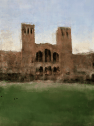

In [18]:
Image(open(os.path.join('nvs_results', scene_name +  'cleantiny' +'_img.gif'), 'rb').read())